In [1]:
from itertools import islice
from collections import defaultdict
import numpy as np
import pandas as pd
import csv
import math
import random
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta
from tqdm import tqdm
import time
import sklearn
from sklearn.decomposition import PCA
from scipy.spatial import distance
import heapq
from scipy import sparse
import copy
import catboost
import gc
import pickle
import matplotlib.pyplot as plt

# 0. Data preparation

In [3]:
# 读取 transaction_train.csv 文件
articles_df =  pd.read_csv(r"./dataSet/articles.csv",dtype = object)
transactions_df = pd.read_csv(r"./dataSet/transactions_train.csv",dtype = object)
transactions_df["t_dat"] = pd.to_datetime(transactions_df["t_dat"])
customers_df = pd.read_csv(r"./dataSet/customers.csv",dtype = object)


In [4]:
icf_matrix =  sparse.load_npz('./ICF_matrix.npz')
item_dict =  np.load('./icf_dict.npy',allow_pickle=True).item()

In [69]:
target_users_before = transactions_df.query("t_dat>=@time_dicter[4][0]")["customer_id"].unique().tolist()
users_before = transactions_df.query("t_dat<@time_dicter[4][0] and t_dat >= @time_dicter[0][0]")["customer_id"].unique().tolist()
test_target_users = pd.Series(list(set(target_users_before).intersection(set(users_before))))
target_users = test_target_users


# 1. Retrival Stage

## Tag Sim

In [7]:
class Tagsim(object):
    def __init__(self, start_date, end_date, transactions_df, articles_df, cids:pd.Series):
        #hyper_parameter
        self.cids = cids
#         self.w2v_matrix = sparse.load_npz('./ICF_matrix.npz')
        #filtered dataFrame
        merging1 = transactions_df.query("@end_date >=t_dat>=@start_date and customer_id in @self.cids.values")[["t_dat","customer_id","article_id"]]
        self.test = merging1
#         print("Merging1 size:",merging1.shape)
#         print("cid values:",cids.values)
        merging2 = articles_df[["article_id","product_group_name","product_type_no"]]
        self.merged_df = pd.merge(merging1, merging2, on='article_id', how='left')

#         print("Merging2 size:",merging2.shape)

        
        # group2type relation
        grouped_df = articles_df.groupby("product_group_name")
        self.dict_group_to_type = {group_name: set(grouped_df.get_group
                                              (group_name)["product_type_no"]
                                              .tolist()) for group_name in grouped_df.groups.keys()}
        # transaction_record
        self.trans_record = pd.merge(transactions_df.query("@end_date >=t_dat>=@start_date")["article_id"], 
                                     merging2, on='article_id', how='left')
    
        #pools
        self.public_pool = list(transactions_df.query("t_dat>=@start_date and t_dat <= @end_date").groupby("article_id").size().nlargest(150).index)
        
    def get_merged_df(self):
        return self.merged_df
    def get_public_df(self):
        return self.public_pool
    def get_test(self):
        return self.test
    def recommand(self):
        df_res = pd.DataFrame(columns = range(150))
        for cid in tqdm(self.cids, desc="Tag sim calculating..."):
            df_res = pd.concat([df_res,self.inner_recommand(cid).to_frame().T])
       
        return df_res
    
    def inner_recommand(self, cid:str):
        
        df_product_info = self.merged_df[self.merged_df["customer_id"] == cid][["article_id","product_group_name","product_type_no"]].drop_duplicates()
        
        
        
        #get brought class direct class and related_class
        dict_related_types = {}
        
        dict_direct_types = {}
        
        dict_brought_articles = {}
        
        
        grouped_df = df_product_info.groupby("product_type_no")
        dict_brought_articles = { type_no: list(set(grouped_df.get_group(type_no)["article_id"].values))
                              for type_no in grouped_df.groups.keys()}
        
        grouped_df = df_product_info.groupby("product_group_name")
        
        for group_name  in grouped_df.groups.keys():
            li_direct_types = set(grouped_df.get_group(group_name)["product_type_no"].values)
            
            li_related_types = set(self.dict_group_to_type[group_name])- li_direct_types
        
            dict_direct_types[group_name] = li_direct_types
            dict_related_types[group_name] = li_related_types
            

        li_articles = []

        if len(dict_brought_articles.keys()) !=0:
            len_each_type = 120/len(dict_brought_articles.keys())


            for group_name, a_types in dict_direct_types.items():
                for a_type in a_types:

                    a_type = a_type


                    li_candidate =self.trans_record.query("product_type_no == @a_type and article_id not in @dict_brought_articles[@a_type]").\
                    groupby("article_id").size().rename("Count").reset_index().nlargest(int(len_each_type*2/3), columns= "Count")["article_id"].values


                    len_for_related = int(len_each_type - len(li_candidate))                  
                    li_related = self.trans_record.query("product_type_no in @dict_related_types[@group_name]"
                                         ).groupby("article_id").size().rename("Count").reset_index().nlargest(len_for_related, columns= "Count")["article_id"].values

                    li_articles+=list(li_candidate)
                    li_articles+= list(li_related)
            
                
        gap_number = 150 - len(li_articles)
        
        public_cadidates = self.public_pool[:gap_number]
        li_articles+= public_cadidates
        
        return pd.Series(li_articles, name = cid)

            
            
        
        

## W2V

In [8]:
class W2V():
    def __init__(self, start_date, end_date, transaction_df,target_users:pd.Series, w2v_num:int):
        #files import& filter
        self.index_file=pd.read_table('./metadata.tsv',names = ["article_id"], sep='\t',dtype = str)
        self.index_file["article_id"] = self.index_file["article_id"].astype("str")
        
        self.vctr_file = pd.read_table('./vectors.tsv',names=  range(128), sep='\t')
        self.target_users = target_users
        self.trans_record_df = transaction_df.query("@end_date >=t_dat>=@start_date and customer_id in @self.target_users")
        
        # hyper-para
        self.num_of_candidate = w2v_num
        component_num = 128
        pca =  PCA(n_components=component_num)
        self.pcad_arr =  pca.fit_transform(self.vctr_file.values)
#         print("Test1")
        
    def recommand(self)->pd.DataFrame: #customer_id作为index
#         print("Test2")

        df_res = pd.DataFrame(columns = range(150),dtype = object)
        for cid in tqdm(self.target_users, desc="w2v calculating..."):
            df_res = pd.concat([df_res,self.inner_recommand(cid).to_frame().T])
        return df_res
        
    
    def inner_recommand(self,cid:str)->pd.Series:
#         print("Test3")

        li_article = list(
            set(self.index_file["article_id"].to_list()).intersection(
            set(self.trans_record_df.query("customer_id == @cid")["article_id"].to_list()) 
            )
        )
        if (len(li_article)!= 0):
            num_per_article = int(self.num_of_candidate/len(li_article))
            
            gap_num = self.num_of_candidate - num_per_article*len(li_article)
            li_gap = [0 for i in range(len(li_article))]
            li_gap[:gap_num] =[1 for i in range(gap_num)] 
            
            temp_res =  pd.Series(dtype=str)
            for i in range(len(li_article)):
                article = li_article[i]
                num_per_article_real = num_per_article+ li_gap[i]
                temp_res = pd.concat([temp_res,self.article_recommand(article,num_per_article_real)],ignore_index=True)

            gap_num = self.num_of_candidate - temp_res.shape[0]
            temp_res = pd.concat([  temp_res, pd.Series([None for i in range(gap_num)],dtype=object)],ignore_index=True)
        else: 
            temp_res = pd.Series([None for i in range(self.num_of_candidate)],dtype=object )
        #gap_handle
        temp_res = temp_res.rename(cid)
        
        
        return temp_res
        
    def article_recommand(self,article_id:str,num_of_candidate:int)->pd.Series:
#         print("Article_id :", article_id)

#         print("Test4")

        matrix_id = self.index_file[self.index_file["article_id"]==article_id].index[0]
        candidate_li = [tuple([0,None]) for i in range(num_of_candidate)]
        heapq.heapify(candidate_li)

        for i in range(len(self.pcad_arr)):
            # 算cos
            if matrix_id != i:
                cos_sim_val = 1 - distance.cosine(self.pcad_arr[i],self.pcad_arr[matrix_id])
                item = tuple( [cos_sim_val, i])

                # heap sort
                if candidate_li[0][0] >= item[0]:
                    continue
                else:
                    heapq.heappop(candidate_li)
                    heapq.heappush(candidate_li,item)
                    
        tmp_li = [item_tup[1] for item_tup in list(candidate_li) if item_tup[1] != 0]
        def get_item(idx:int):
            return self.index_file["article_id"][idx]
        tmp_li = map(get_item, tmp_li)
        return pd.Series(tmp_li,dtype = object)


## ICF

In [9]:
from tqdm import tqdm
import time

class ItemCF(object):
    """ Item based Collaborative Filtering Algorithm Implementation"""
    def __init__(self, start_date, end_date, article_df, transaction_df,
                 target_users:pd.Series,icf_num: int, 
                 icf_matrix:np.array,item_dict:dict):
         
        self.target_users = target_users
        self.item_dict = item_dict
        self.icf_matrix = icf_matrix
        self._itemSimMatrix = dict() # 物品相似度矩阵
        self.start_date = start_date # 始末时间
        self.end_date = end_date
        self.test_res = 0
        self.icf_num = icf_num
        
        cleared_data=transaction_df.drop(['price','sales_channel_id'], axis=1)
#         print("Test 0")
        cleared_data = cleared_data.query("t_dat>= @self.start_date and t_dat<= @self.end_date and customer_id in @target_users.values")
#         print("Test 1.5")

        cleared_data.drop_duplicates(inplace=True)
#         print("Test 1")
        cleared_data["article_idx"] = cleared_data["article_id"].map(item_dict)
        
#         print("Test2")
        self.trans_with_idx = cleared_data      
    
    def get_topK_items(self, aid:int, item_num:int):
        row_data = self.icf_matrix.getrow(aid)

        li_idx = row_data.indices
        li_val = row_data.data

        def take_val(item):
            return item[1]

        zipped = list(zip(li_idx,li_val))
        

        if aid in li_idx.tolist():
            del zipped[li_idx.tolist().index(aid)]
        
        zipped.sort(key = take_val, reverse = True)
        return [ i[0] for i in zipped[:item_num]]
    
    def get_available_items_num (self, aid:int)->int:
        return len(self.icf_matrix.getrow(aid).data) - 1

    def inner_recommend(self, user:str)->pd.Series:
        """
        :param user: 被推荐的用户user
        :param N: 推荐的商品个数
        :return: 按照user对推荐物品的感兴趣程度排序的N个商品
        """
        
        
        recommends = dict()
        # 先获取user的喜爱物品列表
        
        items_idx = self.trans_with_idx[self.trans_with_idx["customer_id"] == user]["article_idx"].unique()
        recommended_item = []

        if len(items_idx) != 0: 

            num_for_recommand = int(self.icf_num/len(items_idx))

            for item_idx in items_idx:

                item_num = min(self.get_available_items_num(item_idx), num_for_recommand) 


                recommended_item.extend(self.get_topK_items(item_idx, item_num))

            reversedict = {v:k for k, v in self.item_dict.items() }

            recommended_item = [ reversedict[item_idx] for item_idx in recommended_item]
        
        gap_num = self.icf_num-len(recommended_item)
        recommended_item.extend([ None for i in range(gap_num)])
        
        res = pd.Series(recommended_item,name = user)

        return res 
        

    
    def recommends(self)-> pd.DataFrame:
        
        df_res = pd.DataFrame(columns = range(150),dtype=object)
        for cid in tqdm(self.target_users, desc="icf calculating..."):
            df_res = pd.concat([df_res, self.inner_recommend(cid).to_frame().T])
       
        return df_res
        

 

# Retrival All

In [10]:


class Recommand_system:
    def __init__(self, articles_df, transactions_df, customer_df, 
                 target_users:pd.Series, 
                 start_date:datetime, end_date:datetime ):
        
        self.icf_matrix =  sparse.load_npz('./ICF_matrix.npz')
        self.item_dict =   np.load('./icf_dict.npy',allow_pickle=True).item()

        self.target_users = pd.Series(target_users.unique())
        self.start_date = start_date
        self.end_date = end_date
        
        
#         self.articles_df = pd.read_csv(article_path,dtype = object)
#         self.transactions_df = pd.read_csv(transaction_path,dtype = object)
        self.articles_df = articles_df
        self.transactions_df = transactions_df
        
        self.customer_df = customer_df
        
        # 相关超参数
        self.icf_num = self.w2v_num = self.tag_num = 50
        
        #处理时间类型
        self.transactions_df["t_dat"] = pd.to_datetime(self.transactions_df["t_dat"])
        
        self.week_dict = self.time_dict(self.start_date,self.end_date,4)
        
        
    
    def time_dict(self,start_time,end_time,m):
         # 计算时间段的总天数和每段时间的天数
        total_days = (end_time - start_time).days
        days_per_segment = total_days // m

        # 初始化结果字典
        result = {}

        segment_start  = segment_end= start_time

        # 依次计算每个时间段的起止时间，并存储到结果字典中
        for i in range(m):
            segment_end += timedelta(days=days_per_segment)
            # 如果是最后一段，结束时间为总结束时间
            if i == m - 1:
                segment_end = end_time
            result[i] = (segment_start, segment_end)

            segment_start = segment_end+ timedelta(days = 1)
            
#         print(result)
        return result
        
    
    def pre_w2v(self, start_date, end_date):
        w2v_estimator = W2V(start_date,end_date,
                transactions_df,self.target_users, self.w2v_num)
        return w2v_estimator.recommand()
        
    def pre_icf(self, start_date, end_date):
        
        icf = ItemCF(start_date,end_date, 
           articles_df, transactions_df, self.target_users,self.icf_num,self.icf_matrix, self.item_dict)
        return  icf.recommends()
    
    def pre_tag(self,start_date,end_date):
        tagsim = Tagsim(start_date,end_date,
                      self.transactions_df, self.articles_df,self.target_users)
        return tagsim.recommand()
    
    def recommand(self):
        df_product = pd.DataFrame(columns=  ["customer_id","week"].extend(list(range(self.icf_num+ self.w2v_num+ self.tag_num))      ))
        for week_index, tup_date in self.week_dict.items():
            # tag_part
            df_tag = self.pre_tag(tup_date[0],tup_date[1]) 
            df_w2v = self.pre_w2v(tup_date[0],tup_date[1])
            df_icf = self.pre_icf(tup_date[0],tup_date[1])
                            
            df_three_together = pd.concat([df_tag,df_w2v, df_icf],axis=1) 
                            
            col_idx = list(range(0, 150)) + list(range(0, 150)) + list(range(0,150))
            new_columns = {col: i for i, col in enumerate(col_idx)}

            df_three_together = df_three_together.rename(columns=new_columns)
                            
            df_three_together["week_tmp"] = week_index
            df_three_together.insert(0,"week",df_three_together.pop("week_tmp"))
            df_three_together = df_three_together.reset_index().rename(columns={"index":"customer_id"})
            

            df_product = pd.concat([df_product, df_three_together])

        df_product = df_product.reset_index(drop=True)
        return df_product

In [70]:
rs = Recommand_system (articles_df,transactions_df,customers_df,target_users,
                 datetime.strptime("2020-08-13", "%Y-%m-%d"),datetime.strptime("2020-09-13", "%Y-%m-%d"))
df_res = rs.recommand()
df_res

w2v calculating...: 100%|██████████| 1000/1000 [12:45<00:00,  1.31it/s]
D:\Users\huiyu\anaconda3\envs\tensorFlow\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
D:\Users\huiyu\anaconda3\envs\tensorFlow\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
w2v calculating...: 100%|██████████| 1000/1000 [12:11<00:00,  1.37it/s]
D:\Users\huiyu\anaconda3\envs\tensorFlow\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is try

,customer_id,week,300,301,302,303,304,305,306,307,...,440,441,442,443,444,445,446,447,448,449
0,354c5f3b7e6ecfb51be1a39b855e5a79d8d44f64a37be2...,0,0916468003,0896152002,0812668001,0894668003,0751471001,0866731001,0610776002,0706016001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,687a52f89964f17943d5027cf88bf8fb8a98f62f5f4651...,0,0916468003,0896152002,0812668001,0894668003,0751471001,0866731001,0610776002,0706016001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,166645c17b8653400e026623146d5471316d36ca45f781...,0,0916468003,0896152002,0812668001,0894668003,0751471001,0866731001,0610776002,0706016001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18ca5213269433838295bdfa690a299b67efb0a3b3869a...,0,0916468003,0896152002,0812668001,0894668003,0751471001,0866731001,0610776002,0706016001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,f71152b4b3b463811279d839a238c42dfb54a4bf5e8e52...,0,0916468003,0896152002,0812668001,0894668003,0751471001,0866731001,0610776002,0706016001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,cb62efb5027b4dd4cec607bc4c62b2a1eb0daa4cbbbe5e...,3,0909370001,0751471001,0448509014,0918522001,0751471043,0915526001,0706016001,0918292001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3996,9f3f9a7ac3274f6aea85516bc90882f7daadc524dec006...,3,0751471001,0448509014,0751471043,0706016001,0865799006,0919365008,0783346001,0909911001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,a52f4ee56b0f353c76d841e6e1bdc1890ca92fbc04eda5...,3,0909370001,0751471001,0448509014,0918522001,0751471043,0915526001,0706016001,0918292001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3998,b4fbaa7f6db329601c4c9d785245d45ea455ede953385d...,3,0909370001,0751471001,0448509014,0918522001,0751471043,0915526001,0706016001,0918292001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
def df_transpose(df): 
    df_res = pd.DataFrame(columns=["customer_id","week","article_id"])
    row_num = df.shape[0]
    for row_idx in tqdm(range(row_num),desc = "Dataframe processing..."):
        series = df.iloc[row_idx] 
        series_cid = series["customer_id"]
        series_week = series["week"]
        
#         print(series)
#         print(series.iloc[2:].unique().tolist())
        li_aid = series.iloc[2:].unique().tolist()
        
        if None in li_aid:
            li_aid.remove(None)
        if np.nan in li_aid:
            li_aid.remove(np.nan)
            
        for series_aid in li_aid:
            tmp = pd.Series([series_cid, series_week,series_aid], index=["customer_id","week","article_id"])
            new_row = tmp.to_frame().T
            df_res = pd.concat([df_res, new_row], axis=0, ignore_index=True)
            
    return df_res

In [71]:
retrival_res = df_transpose(df_res)
retrival_res

Dataframe processing...: 100%|██████████| 4000/4000 [1:25:07<00:00,  1.28s/it]


,customer_id,week,article_id
0,354c5f3b7e6ecfb51be1a39b855e5a79d8d44f64a37be2...,0,0916468003
1,354c5f3b7e6ecfb51be1a39b855e5a79d8d44f64a37be2...,0,0896152002
2,354c5f3b7e6ecfb51be1a39b855e5a79d8d44f64a37be2...,0,0812668001
3,354c5f3b7e6ecfb51be1a39b855e5a79d8d44f64a37be2...,0,0894668003
4,354c5f3b7e6ecfb51be1a39b855e5a79d8d44f64a37be2...,0,0751471001
...,...,...,...
697886,e7e8470d6440fcbd66987e0bbb99b005f9d87dad7d51e3...,3,0892416001
697887,e7e8470d6440fcbd66987e0bbb99b005f9d87dad7d51e3...,3,0787172001
697888,e7e8470d6440fcbd66987e0bbb99b005f9d87dad7d51e3...,3,0795311013
697889,e7e8470d6440fcbd66987e0bbb99b005f9d87dad7d51e3...,3,0919391001


#  Feature Engineering

In [72]:
def add_feature(transactions_df, articles_df, customers_df, retrival_per_week,week: int, time_dicter:dict )->pd.DataFrame:

    ARTICLES_ORIGINAL = {
    'article_id': 'object',
    'product_code': 'int64',
    'prod_name': 'object',
    'product_type_no': 'int64',
    'product_type_name': 'object',
    'product_group_name': 'object',
    'graphical_appearance_no': 'int64',
    'graphical_appearance_name': 'object',
    'colour_group_code': 'int64',
    'colour_group_name': 'object',
    'perceived_colour_value_id': 'int64',
    'perceived_colour_value_name': 'object',
    'perceived_colour_master_id': 'int64',
    'perceived_colour_master_name': 'object',
    'department_no': 'int64',
    'department_name': 'object',
    'index_code': 'object',
    'index_name': 'object',
    'index_group_no': 'int64',
    'index_group_name': 'object',
    'section_no': 'int64',
    'section_name': 'object',
    'garment_group_no': 'int64',
    'garment_group_name': 'object',
    'detail_desc': 'object',
    }

    CUSTOMERS_ORIGINAL = {
        'customer_id': 'object',
        'FN': 'float64',
        'Active': 'float64',
        'club_member_status': 'object',
        'fashion_news_frequency': 'object',
        'age': 'float64',
        'postal_code': 'object',
    }

    TRANSACTIONS_ORIGINAL = {
        'customer_id': 'object',
        'article_id': 'object',
        'price': 'float64',
        'sales_channel_id': 'int64',
    }
    
    
    
    
    tmp_transactions_df = transactions_df.astype(dtype =TRANSACTIONS_ORIGINAL )
    tmp_customers_df = customers_df.astype(dtype = CUSTOMERS_ORIGINAL )
    tmp_articles_df = articles_df.astype(dtype= ARTICLES_ORIGINAL)
    
    transactions_df["sales_channel_id"] = tmp_transactions_df["sales_channel_id"].fillna(-1)
    transactions_df["price"] = tmp_transactions_df["price"].fillna(-1)
    tmp_customers_df["age"] = tmp_customers_df["age"].fillna(-1)

    
    viewable_start_date = time_dicter[week][0]
    viewable_end_date = time_dicter[len(time_dicter.keys())-1][1]
    transactions_aval_all_df = tmp_transactions_df.query("@viewable_start_date <= t_dat ")
    transactions_aval_train_df = tmp_transactions_df.query("@viewable_start_date <= t_dat <= @viewable_end_date")
    
    df = copy.deepcopy(retrival_per_week)
    
    
    # user静态特征, 加入年龄

    df = df.merge(tmp_customers_df[['customer_id', 'age']], on='customer_id', how = "inner")

    # item静态特征，所有idx结尾特征
    article_features = [c for c in articles_df.columns if c.endswith('no') or 
                     c.endswith('code') 
                     or c.endswith('id') 
                    or c == "product_group_name"]
   
    
    df = pd.merge( df,articles_df[ article_features],on='article_id' , how="inner")
    
#      # item动态特征 (transactions)
#     # [price 和 sales_channel_id]的[平均值,标准差] 'article__price float   article_sales_channel_id float
    tmp = transactions_aval_train_df.groupby('article_id')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['article_' + '_'.join(a) for a in tmp.columns.to_flat_index()] # 加入列名后缀
    tmp.reset_index(inplace = True)
#     print(tmp.head(10))

    df = pd.merge(df, tmp, on='article_id', how='left') # merge新列
    
#     print("Hello")
#     print(type(df["article_sales_channel_id_mean"]))

    
#     # customer动态特征  (user features) age_mean float64 age_std float64
#     # 交易表某段week，加入年龄列
    tmp = pd.merge(transactions_aval_train_df,
                   tmp_customers_df[['customer_id', 'age']], on='customer_id',how = "left")
    tmp = tmp.groupby('customer_id')['age'].agg(['mean', 'std']) # 每个article的购买年龄的[mean和std]
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()] # 加入列名后缀
    df = pd.merge(df,tmp, on='customer_id', how='left') # merge新列
    
    df.fillna(-1)
    
#   article_day_min int
    tmp = transactions_aval_all_df.groupby('article_id')['t_dat'].min().reset_index(name='article_day_min')
    tmp['article_day_min'] -= time_dicter[week][0] # article有多少天没有被购买了。
    df = pd.merge(df,tmp, on='article_id', how='left') # merge新列 

#     article_volume: int 
    tmp = transactions_aval_train_df.groupby('article_id').size().reset_index(name='article_volume') 
    df = pd.merge(df,tmp, on='article_id', how='left')
    
#      customer_day_min: int
    tmp = transactions_aval_train_df.groupby('customer_id')['t_dat'].min().reset_index(name='customer_day_min') # 每个customer最近一次购买的day
    tmp['customer_day_min'] -= time_dicter[week][0] # 该customer有多少天没有购买了
    df = pd.merge(df,tmp, on='customer_id', how='left')
    
#      customer_volume: int
    tmp = transactions_aval_train_df.groupby('customer_id').size().reset_index(name='customer_volume') # 每个customer购买量
    df = pd.merge(df,tmp, on='customer_id', how='left') 
    




    return df.reset_index(drop=True)

In [73]:
# 分train valid set
ava_week_num = 4
valid_set = []
train_set = pd.DataFrame()# 要根据特征改
for week in tqdm(range(ava_week_num), desc = "feature_labelling..."):
    retrival_per_week = retrival_res.groupby("week").get_group(week)
    featured_retrival_per_week = add_feature(transactions_df, articles_df, customers_df, retrival_per_week, week, time_dicter)

    if week == ava_week_num - 1:
        valid_set = featured_retrival_per_week
    else:
        train_set = pd.concat([featured_retrival_per_week , train_set],ignore_index=True)


feature_labelling...: 100%|██████████| 4/4 [00:25<00:00,  6.45s/it]


In [75]:
def attach_label(transactions_df:pd.DataFrame, train_set:pd.DataFrame, 
                 articles_df:pd.DataFrame,customers_id: pd.DataFrame, time_dicter:dict,total_week_num:int)->pd.DataFrame:
    
    
    start_date = time_dicter[0][0]
    end_date = time_dicter[total_week_num][1]
    
    cids = train_set["customer_id"].values
    
    article_features = [c for c in articles_df.columns if c.endswith('no') or 
                     c.endswith('code') 
                     or c.endswith('id') 
                    or c == "product_group_name"]
    
    merging1 = transactions_df.query(" @end_date >=t_dat>= @start_date and customer_id in @cids")[["t_dat","customer_id","article_id"]]
#     merging2 = articles_df[article_features]
    
#     merged_df = pd.merge(merging1,merging2, on = "article_id",how = "left")
#     merged_df = pd.merge(merged_df, customers_df[["customer_id","age"]], on="customer_id", how= "left")
    merged_df = merging1
    
    df_res = pd.DataFrame()
    for week in range(total_week_num):

        df_train_per_week = train_set.query("week == @week")
        
        df_merged_per_week = merged_df.query("@time_dicter[@week+1][0]<=t_dat") # 可改
        df_merged_per_week = df_merged_per_week.drop("t_dat",axis=1)
        df_merged_per_week["week"] = week
        df_merged_per_week["y"] = 1
        
        df_merged_per_week["week"] = df_merged_per_week["week"].astype(int)
        df_merged_per_week["y"] = df_merged_per_week["y"].astype(int)
        
#         print("Data type: ")
#         print(df_train_per_week.dtypes)
#         print(df_merged_per_week.dtypes)

        train_per_week = pd.merge(df_train_per_week,df_merged_per_week, how = "left" ) #how 可改
        train_per_week["y"] = train_per_week["y"].fillna(0)
        
#         print("The data before filter:")
#         print(train_per_week.shape)
        
        labels = train_per_week
        labels = labels[labels['customer_id'].isin(labels[['customer_id', 'y']].drop_duplicates().groupby('customer_id').size().reset_index(name='sz').query("sz==2")["customer_id"])].reset_index(drop=True)
        
#         print("The data after filter:")
#         print(labels.shape)
        
        df_res = pd.concat([df_res, labels])
        
    df_res["week"] = df_res["week"].astype(int)
    df_res["y"] = df_res["y"].astype(int)
    
#     print("The data before")
    return df_res

In [76]:
labelled_train_df = attach_label(transactions_df, train_set,
                 articles_df,customers_df, time_dicter,3)
labelled_valid_df = attach_label(transactions_df, valid_set,
                 articles_df,customers_df, time_dicter,4)

labelled_valid_df = labelled_valid_df.sort_index(axis=1)
labelled_train_df = labelled_train_df.sort_index(axis=1)

drop_list = ['age_std','article_day_min','index_code', 'section_no','graphical_appearance_no']
labelled_train_df.drop(drop_list,axis=1,inplace=True)
labelled_valid_df.drop(drop_list,axis=1,inplace=True)

labelled_train_df.dropna(inplace=True)
labelled_valid_df.dropna(inplace=True)

In [78]:
# 按week、user排序 整理

labelled_train_df["query_group"] = labelled_train_df["week"].astype(str)+ "_" + labelled_train_df["customer_id"].astype(str)
labelled_valid_df["query_group"] = labelled_valid_df["week"].astype(str)+ "_" + labelled_valid_df["customer_id"].astype(str)
labelled_train_df=labelled_train_df.sort_values(by='query_group').reset_index(drop=True)
labelled_valid_df = labelled_valid_df.sort_values(by='query_group').reset_index(drop=True)

labelled_train_df.sort_index(axis = 1,inplace = True)
labelled_valid_df.sort_index(axis = 1, inplace = True)
#{0 1 2 } |3 | 4

# 特征列
feature_columns = [c for c in labelled_train_df.columns if c not in ['y', "article_id",'customer_id', 'query_group', 'week',"customer_day_min"]] # 
# 按week、user排序 整理
# 标签编码特征 
cat_feature_values = [c for c in feature_columns if c in ["product_group_name", "index_code"] or c.endswith("day_min")] 
cat_features = [feature_columns.index(c) for c in cat_feature_values] 



# Ranking stage


In [79]:
train = labelled_train_df
valid = labelled_valid_df

train_dataset = catboost.Pool(data=train[feature_columns], 
                              label=train['y'], 
                              group_id=train['query_group'], 
                              cat_features=cat_features)
valid_dataset = catboost.Pool(data=valid[feature_columns], 
                              label=valid['y'], 
                              group_id=valid['query_group'], 
                              cat_features=cat_features)

params = {
    'loss_function': 'YetiRank',
    'use_best_model': True,
    'one_hot_max_size': 300,
    'iterations': 10000,
}
model = catboost.CatBoost(params) # 创建模型
model.fit(train_dataset, eval_set=valid_dataset) # 训练模型



0:	test: 0.0680207	best: 0.0680207 (0)	total: 34.5ms	remaining: 5m 44s
1:	test: 0.1329068	best: 0.1329068 (1)	total: 65.6ms	remaining: 5m 28s
2:	test: 0.1357347	best: 0.1357347 (2)	total: 95ms	remaining: 5m 16s
3:	test: 0.1456850	best: 0.1456850 (3)	total: 125ms	remaining: 5m 11s
4:	test: 0.1454719	best: 0.1456850 (3)	total: 153ms	remaining: 5m 6s
5:	test: 0.1445930	best: 0.1456850 (3)	total: 181ms	remaining: 5m 1s
6:	test: 0.1472360	best: 0.1472360 (6)	total: 211ms	remaining: 5m 1s
7:	test: 0.1485323	best: 0.1485323 (7)	total: 240ms	remaining: 4m 59s
8:	test: 0.1482988	best: 0.1485323 (7)	total: 271ms	remaining: 5m
9:	test: 0.1462410	best: 0.1485323 (7)	total: 301ms	remaining: 5m
10:	test: 0.1471216	best: 0.1485323 (7)	total: 329ms	remaining: 4m 58s
11:	test: 0.1498003	best: 0.1498003 (11)	total: 359ms	remaining: 4m 58s
12:	test: 0.1472108	best: 0.1498003 (11)	total: 388ms	remaining: 4m 58s
13:	test: 0.1434611	best: 0.1498003 (11)	total: 417ms	remaining: 4m 57s
14:	test: 0.1427141	bes

117:	test: 0.1259938	best: 0.1498003 (11)	total: 3.41s	remaining: 4m 45s
118:	test: 0.1252664	best: 0.1498003 (11)	total: 3.43s	remaining: 4m 45s
119:	test: 0.1263631	best: 0.1498003 (11)	total: 3.46s	remaining: 4m 45s
120:	test: 0.1232955	best: 0.1498003 (11)	total: 3.49s	remaining: 4m 44s
121:	test: 0.1225234	best: 0.1498003 (11)	total: 3.52s	remaining: 4m 44s
122:	test: 0.1225185	best: 0.1498003 (11)	total: 3.54s	remaining: 4m 44s
123:	test: 0.1223440	best: 0.1498003 (11)	total: 3.57s	remaining: 4m 44s
124:	test: 0.1213796	best: 0.1498003 (11)	total: 3.6s	remaining: 4m 44s
125:	test: 0.1220642	best: 0.1498003 (11)	total: 3.62s	remaining: 4m 43s
126:	test: 0.1217863	best: 0.1498003 (11)	total: 3.65s	remaining: 4m 43s
127:	test: 0.1212968	best: 0.1498003 (11)	total: 3.68s	remaining: 4m 43s
128:	test: 0.1211713	best: 0.1498003 (11)	total: 3.7s	remaining: 4m 43s
129:	test: 0.1215211	best: 0.1498003 (11)	total: 3.73s	remaining: 4m 43s
130:	test: 0.1215261	best: 0.1498003 (11)	total: 3.76

230:	test: 0.1146893	best: 0.1498003 (11)	total: 6.45s	remaining: 4m 32s
231:	test: 0.1148628	best: 0.1498003 (11)	total: 6.48s	remaining: 4m 32s
232:	test: 0.1147831	best: 0.1498003 (11)	total: 6.51s	remaining: 4m 32s
233:	test: 0.1144982	best: 0.1498003 (11)	total: 6.54s	remaining: 4m 32s
234:	test: 0.1120919	best: 0.1498003 (11)	total: 6.56s	remaining: 4m 32s
235:	test: 0.1118347	best: 0.1498003 (11)	total: 6.59s	remaining: 4m 32s
236:	test: 0.1132263	best: 0.1498003 (11)	total: 6.62s	remaining: 4m 32s
237:	test: 0.1134601	best: 0.1498003 (11)	total: 6.65s	remaining: 4m 32s
238:	test: 0.1133904	best: 0.1498003 (11)	total: 6.68s	remaining: 4m 32s
239:	test: 0.1114232	best: 0.1498003 (11)	total: 6.71s	remaining: 4m 32s
240:	test: 0.1127077	best: 0.1498003 (11)	total: 6.74s	remaining: 4m 32s
241:	test: 0.1126985	best: 0.1498003 (11)	total: 6.77s	remaining: 4m 32s
242:	test: 0.1134020	best: 0.1498003 (11)	total: 6.79s	remaining: 4m 32s
243:	test: 0.1126172	best: 0.1498003 (11)	total: 6.

347:	test: 0.1107524	best: 0.1498003 (11)	total: 9.59s	remaining: 4m 25s
348:	test: 0.1102631	best: 0.1498003 (11)	total: 9.62s	remaining: 4m 25s
349:	test: 0.1117122	best: 0.1498003 (11)	total: 9.64s	remaining: 4m 25s
350:	test: 0.1111186	best: 0.1498003 (11)	total: 9.67s	remaining: 4m 25s
351:	test: 0.1111984	best: 0.1498003 (11)	total: 9.69s	remaining: 4m 25s
352:	test: 0.1108885	best: 0.1498003 (11)	total: 9.72s	remaining: 4m 25s
353:	test: 0.1105554	best: 0.1498003 (11)	total: 9.74s	remaining: 4m 25s
354:	test: 0.1102223	best: 0.1498003 (11)	total: 9.77s	remaining: 4m 25s
355:	test: 0.1101918	best: 0.1498003 (11)	total: 9.8s	remaining: 4m 25s
356:	test: 0.1108203	best: 0.1498003 (11)	total: 9.82s	remaining: 4m 25s
357:	test: 0.1108125	best: 0.1498003 (11)	total: 9.85s	remaining: 4m 25s
358:	test: 0.1108137	best: 0.1498003 (11)	total: 9.88s	remaining: 4m 25s
359:	test: 0.1114541	best: 0.1498003 (11)	total: 9.9s	remaining: 4m 25s
360:	test: 0.1118713	best: 0.1498003 (11)	total: 9.93

462:	test: 0.1103809	best: 0.1498003 (11)	total: 12.6s	remaining: 4m 20s
463:	test: 0.1105030	best: 0.1498003 (11)	total: 12.7s	remaining: 4m 20s
464:	test: 0.1105580	best: 0.1498003 (11)	total: 12.7s	remaining: 4m 20s
465:	test: 0.1105800	best: 0.1498003 (11)	total: 12.7s	remaining: 4m 20s
466:	test: 0.1110400	best: 0.1498003 (11)	total: 12.8s	remaining: 4m 20s
467:	test: 0.1115526	best: 0.1498003 (11)	total: 12.8s	remaining: 4m 20s
468:	test: 0.1115790	best: 0.1498003 (11)	total: 12.8s	remaining: 4m 20s
469:	test: 0.1111544	best: 0.1498003 (11)	total: 12.8s	remaining: 4m 20s
470:	test: 0.1110061	best: 0.1498003 (11)	total: 12.9s	remaining: 4m 20s
471:	test: 0.1104273	best: 0.1498003 (11)	total: 12.9s	remaining: 4m 20s
472:	test: 0.1117324	best: 0.1498003 (11)	total: 12.9s	remaining: 4m 20s
473:	test: 0.1116925	best: 0.1498003 (11)	total: 12.9s	remaining: 4m 20s
474:	test: 0.1115893	best: 0.1498003 (11)	total: 13s	remaining: 4m 20s
475:	test: 0.1114294	best: 0.1498003 (11)	total: 13s	

582:	test: 0.1078618	best: 0.1498003 (11)	total: 15.9s	remaining: 4m 16s
583:	test: 0.1089156	best: 0.1498003 (11)	total: 15.9s	remaining: 4m 16s
584:	test: 0.1091282	best: 0.1498003 (11)	total: 16s	remaining: 4m 16s
585:	test: 0.1092516	best: 0.1498003 (11)	total: 16s	remaining: 4m 16s
586:	test: 0.1088557	best: 0.1498003 (11)	total: 16s	remaining: 4m 16s
587:	test: 0.1096543	best: 0.1498003 (11)	total: 16s	remaining: 4m 16s
588:	test: 0.1096633	best: 0.1498003 (11)	total: 16.1s	remaining: 4m 16s
589:	test: 0.1099382	best: 0.1498003 (11)	total: 16.1s	remaining: 4m 16s
590:	test: 0.1096152	best: 0.1498003 (11)	total: 16.1s	remaining: 4m 16s
591:	test: 0.1099540	best: 0.1498003 (11)	total: 16.2s	remaining: 4m 16s
592:	test: 0.1101627	best: 0.1498003 (11)	total: 16.2s	remaining: 4m 16s
593:	test: 0.1102189	best: 0.1498003 (11)	total: 16.2s	remaining: 4m 16s
594:	test: 0.1104013	best: 0.1498003 (11)	total: 16.2s	remaining: 4m 16s
595:	test: 0.1099115	best: 0.1498003 (11)	total: 16.3s	rema

702:	test: 0.1079516	best: 0.1498003 (11)	total: 19.2s	remaining: 4m 13s
703:	test: 0.1073596	best: 0.1498003 (11)	total: 19.2s	remaining: 4m 13s
704:	test: 0.1070520	best: 0.1498003 (11)	total: 19.2s	remaining: 4m 13s
705:	test: 0.1072136	best: 0.1498003 (11)	total: 19.3s	remaining: 4m 13s
706:	test: 0.1078734	best: 0.1498003 (11)	total: 19.3s	remaining: 4m 13s
707:	test: 0.1086487	best: 0.1498003 (11)	total: 19.3s	remaining: 4m 13s
708:	test: 0.1093369	best: 0.1498003 (11)	total: 19.3s	remaining: 4m 13s
709:	test: 0.1092280	best: 0.1498003 (11)	total: 19.4s	remaining: 4m 13s
710:	test: 0.1084098	best: 0.1498003 (11)	total: 19.4s	remaining: 4m 13s
711:	test: 0.1086663	best: 0.1498003 (11)	total: 19.4s	remaining: 4m 13s
712:	test: 0.1087916	best: 0.1498003 (11)	total: 19.5s	remaining: 4m 13s
713:	test: 0.1087937	best: 0.1498003 (11)	total: 19.5s	remaining: 4m 13s
714:	test: 0.1099023	best: 0.1498003 (11)	total: 19.5s	remaining: 4m 13s
715:	test: 0.1093545	best: 0.1498003 (11)	total: 19

817:	test: 0.1111522	best: 0.1498003 (11)	total: 22.2s	remaining: 4m 9s
818:	test: 0.1119746	best: 0.1498003 (11)	total: 22.3s	remaining: 4m 9s
819:	test: 0.1110228	best: 0.1498003 (11)	total: 22.3s	remaining: 4m 9s
820:	test: 0.1099673	best: 0.1498003 (11)	total: 22.3s	remaining: 4m 9s
821:	test: 0.1097368	best: 0.1498003 (11)	total: 22.3s	remaining: 4m 9s
822:	test: 0.1101654	best: 0.1498003 (11)	total: 22.4s	remaining: 4m 9s
823:	test: 0.1102629	best: 0.1498003 (11)	total: 22.4s	remaining: 4m 9s
824:	test: 0.1101555	best: 0.1498003 (11)	total: 22.4s	remaining: 4m 9s
825:	test: 0.1103916	best: 0.1498003 (11)	total: 22.5s	remaining: 4m 9s
826:	test: 0.1106574	best: 0.1498003 (11)	total: 22.5s	remaining: 4m 9s
827:	test: 0.1107047	best: 0.1498003 (11)	total: 22.5s	remaining: 4m 9s
828:	test: 0.1098310	best: 0.1498003 (11)	total: 22.5s	remaining: 4m 9s
829:	test: 0.1093220	best: 0.1498003 (11)	total: 22.6s	remaining: 4m 9s
830:	test: 0.1094872	best: 0.1498003 (11)	total: 22.6s	remaining

933:	test: 0.1092506	best: 0.1498003 (11)	total: 25.3s	remaining: 4m 5s
934:	test: 0.1098935	best: 0.1498003 (11)	total: 25.3s	remaining: 4m 5s
935:	test: 0.1095331	best: 0.1498003 (11)	total: 25.4s	remaining: 4m 5s
936:	test: 0.1099288	best: 0.1498003 (11)	total: 25.4s	remaining: 4m 5s
937:	test: 0.1098647	best: 0.1498003 (11)	total: 25.4s	remaining: 4m 5s
938:	test: 0.1094201	best: 0.1498003 (11)	total: 25.4s	remaining: 4m 5s
939:	test: 0.1099455	best: 0.1498003 (11)	total: 25.5s	remaining: 4m 5s
940:	test: 0.1094505	best: 0.1498003 (11)	total: 25.5s	remaining: 4m 5s
941:	test: 0.1091192	best: 0.1498003 (11)	total: 25.5s	remaining: 4m 5s
942:	test: 0.1094258	best: 0.1498003 (11)	total: 25.6s	remaining: 4m 5s
943:	test: 0.1102625	best: 0.1498003 (11)	total: 25.6s	remaining: 4m 5s
944:	test: 0.1090633	best: 0.1498003 (11)	total: 25.6s	remaining: 4m 5s
945:	test: 0.1078334	best: 0.1498003 (11)	total: 25.6s	remaining: 4m 5s
946:	test: 0.1079888	best: 0.1498003 (11)	total: 25.7s	remaining

1047:	test: 0.1039452	best: 0.1498003 (11)	total: 28.3s	remaining: 4m 2s
1048:	test: 0.1042151	best: 0.1498003 (11)	total: 28.4s	remaining: 4m 2s
1049:	test: 0.1034730	best: 0.1498003 (11)	total: 28.4s	remaining: 4m 1s
1050:	test: 0.1042720	best: 0.1498003 (11)	total: 28.4s	remaining: 4m 1s
1051:	test: 0.1034104	best: 0.1498003 (11)	total: 28.4s	remaining: 4m 1s
1052:	test: 0.1036351	best: 0.1498003 (11)	total: 28.5s	remaining: 4m 1s
1053:	test: 0.1043267	best: 0.1498003 (11)	total: 28.5s	remaining: 4m 1s
1054:	test: 0.1034160	best: 0.1498003 (11)	total: 28.5s	remaining: 4m 1s
1055:	test: 0.1040546	best: 0.1498003 (11)	total: 28.5s	remaining: 4m 1s
1056:	test: 0.1034053	best: 0.1498003 (11)	total: 28.6s	remaining: 4m 1s
1057:	test: 0.1037647	best: 0.1498003 (11)	total: 28.6s	remaining: 4m 1s
1058:	test: 0.1037761	best: 0.1498003 (11)	total: 28.6s	remaining: 4m 1s
1059:	test: 0.1037317	best: 0.1498003 (11)	total: 28.7s	remaining: 4m 1s
1060:	test: 0.1034079	best: 0.1498003 (11)	total: 2

1167:	test: 0.0985517	best: 0.1498003 (11)	total: 31.6s	remaining: 3m 58s
1168:	test: 0.0991875	best: 0.1498003 (11)	total: 31.6s	remaining: 3m 58s
1169:	test: 0.0987387	best: 0.1498003 (11)	total: 31.6s	remaining: 3m 58s
1170:	test: 0.0991838	best: 0.1498003 (11)	total: 31.7s	remaining: 3m 58s
1171:	test: 0.0981516	best: 0.1498003 (11)	total: 31.7s	remaining: 3m 58s
1172:	test: 0.0983574	best: 0.1498003 (11)	total: 31.7s	remaining: 3m 58s
1173:	test: 0.0978801	best: 0.1498003 (11)	total: 31.8s	remaining: 3m 58s
1174:	test: 0.0986806	best: 0.1498003 (11)	total: 31.8s	remaining: 3m 58s
1175:	test: 0.0991167	best: 0.1498003 (11)	total: 31.8s	remaining: 3m 58s
1176:	test: 0.0984017	best: 0.1498003 (11)	total: 31.8s	remaining: 3m 58s
1177:	test: 0.0983582	best: 0.1498003 (11)	total: 31.9s	remaining: 3m 58s
1178:	test: 0.0983426	best: 0.1498003 (11)	total: 31.9s	remaining: 3m 58s
1179:	test: 0.0987043	best: 0.1498003 (11)	total: 31.9s	remaining: 3m 58s
1180:	test: 0.0984474	best: 0.1498003 

1279:	test: 0.0981761	best: 0.1498003 (11)	total: 34.6s	remaining: 3m 55s
1280:	test: 0.0980704	best: 0.1498003 (11)	total: 34.6s	remaining: 3m 55s
1281:	test: 0.0977235	best: 0.1498003 (11)	total: 34.7s	remaining: 3m 55s
1282:	test: 0.0981802	best: 0.1498003 (11)	total: 34.7s	remaining: 3m 55s
1283:	test: 0.0980252	best: 0.1498003 (11)	total: 34.7s	remaining: 3m 55s
1284:	test: 0.0991194	best: 0.1498003 (11)	total: 34.8s	remaining: 3m 55s
1285:	test: 0.0990543	best: 0.1498003 (11)	total: 34.8s	remaining: 3m 55s
1286:	test: 0.0989755	best: 0.1498003 (11)	total: 34.8s	remaining: 3m 55s
1287:	test: 0.0991966	best: 0.1498003 (11)	total: 34.8s	remaining: 3m 55s
1288:	test: 0.0992206	best: 0.1498003 (11)	total: 34.9s	remaining: 3m 55s
1289:	test: 0.0994776	best: 0.1498003 (11)	total: 34.9s	remaining: 3m 55s
1290:	test: 0.0994778	best: 0.1498003 (11)	total: 34.9s	remaining: 3m 55s
1291:	test: 0.0998788	best: 0.1498003 (11)	total: 35s	remaining: 3m 55s
1292:	test: 0.1001847	best: 0.1498003 (1

1392:	test: 0.0993873	best: 0.1498003 (11)	total: 37.6s	remaining: 3m 52s
1393:	test: 0.0990646	best: 0.1498003 (11)	total: 37.6s	remaining: 3m 52s
1394:	test: 0.0985956	best: 0.1498003 (11)	total: 37.7s	remaining: 3m 52s
1395:	test: 0.0984414	best: 0.1498003 (11)	total: 37.7s	remaining: 3m 52s
1396:	test: 0.0987288	best: 0.1498003 (11)	total: 37.7s	remaining: 3m 52s
1397:	test: 0.0987404	best: 0.1498003 (11)	total: 37.8s	remaining: 3m 52s
1398:	test: 0.0986898	best: 0.1498003 (11)	total: 37.8s	remaining: 3m 52s
1399:	test: 0.0986654	best: 0.1498003 (11)	total: 37.8s	remaining: 3m 52s
1400:	test: 0.0984525	best: 0.1498003 (11)	total: 37.8s	remaining: 3m 52s
1401:	test: 0.0987626	best: 0.1498003 (11)	total: 37.9s	remaining: 3m 52s
1402:	test: 0.0977944	best: 0.1498003 (11)	total: 37.9s	remaining: 3m 52s
1403:	test: 0.0978388	best: 0.1498003 (11)	total: 37.9s	remaining: 3m 52s
1404:	test: 0.0968748	best: 0.1498003 (11)	total: 37.9s	remaining: 3m 52s
1405:	test: 0.0967441	best: 0.1498003 

1504:	test: 0.0963192	best: 0.1498003 (11)	total: 40.6s	remaining: 3m 49s
1505:	test: 0.0971919	best: 0.1498003 (11)	total: 40.6s	remaining: 3m 49s
1506:	test: 0.0977171	best: 0.1498003 (11)	total: 40.6s	remaining: 3m 49s
1507:	test: 0.0975776	best: 0.1498003 (11)	total: 40.7s	remaining: 3m 48s
1508:	test: 0.0979078	best: 0.1498003 (11)	total: 40.7s	remaining: 3m 48s
1509:	test: 0.0975744	best: 0.1498003 (11)	total: 40.7s	remaining: 3m 48s
1510:	test: 0.0975873	best: 0.1498003 (11)	total: 40.7s	remaining: 3m 48s
1511:	test: 0.0977567	best: 0.1498003 (11)	total: 40.8s	remaining: 3m 48s
1512:	test: 0.0976554	best: 0.1498003 (11)	total: 40.8s	remaining: 3m 48s
1513:	test: 0.0976784	best: 0.1498003 (11)	total: 40.8s	remaining: 3m 48s
1514:	test: 0.0976891	best: 0.1498003 (11)	total: 40.8s	remaining: 3m 48s
1515:	test: 0.0978271	best: 0.1498003 (11)	total: 40.9s	remaining: 3m 48s
1516:	test: 0.0977076	best: 0.1498003 (11)	total: 40.9s	remaining: 3m 48s
1517:	test: 0.0975619	best: 0.1498003 

1616:	test: 0.0956333	best: 0.1498003 (11)	total: 43.6s	remaining: 3m 46s
1617:	test: 0.0960812	best: 0.1498003 (11)	total: 43.7s	remaining: 3m 46s
1618:	test: 0.0960839	best: 0.1498003 (11)	total: 43.7s	remaining: 3m 46s
1619:	test: 0.0952816	best: 0.1498003 (11)	total: 43.7s	remaining: 3m 46s
1620:	test: 0.0948935	best: 0.1498003 (11)	total: 43.7s	remaining: 3m 46s
1621:	test: 0.0951071	best: 0.1498003 (11)	total: 43.8s	remaining: 3m 46s
1622:	test: 0.0948439	best: 0.1498003 (11)	total: 43.8s	remaining: 3m 46s
1623:	test: 0.0948002	best: 0.1498003 (11)	total: 43.8s	remaining: 3m 46s
1624:	test: 0.0955289	best: 0.1498003 (11)	total: 43.9s	remaining: 3m 46s
1625:	test: 0.0957246	best: 0.1498003 (11)	total: 43.9s	remaining: 3m 45s
1626:	test: 0.0946478	best: 0.1498003 (11)	total: 43.9s	remaining: 3m 45s
1627:	test: 0.0951475	best: 0.1498003 (11)	total: 43.9s	remaining: 3m 45s
1628:	test: 0.0960562	best: 0.1498003 (11)	total: 44s	remaining: 3m 45s
1629:	test: 0.0961313	best: 0.1498003 (1

1734:	test: 0.0925459	best: 0.1498003 (11)	total: 47s	remaining: 3m 43s
1735:	test: 0.0926439	best: 0.1498003 (11)	total: 47s	remaining: 3m 43s
1736:	test: 0.0923574	best: 0.1498003 (11)	total: 47s	remaining: 3m 43s
1737:	test: 0.0926288	best: 0.1498003 (11)	total: 47.1s	remaining: 3m 43s
1738:	test: 0.0923574	best: 0.1498003 (11)	total: 47.1s	remaining: 3m 43s
1739:	test: 0.0930755	best: 0.1498003 (11)	total: 47.1s	remaining: 3m 43s
1740:	test: 0.0921925	best: 0.1498003 (11)	total: 47.2s	remaining: 3m 43s
1741:	test: 0.0919782	best: 0.1498003 (11)	total: 47.2s	remaining: 3m 43s
1742:	test: 0.0926704	best: 0.1498003 (11)	total: 47.2s	remaining: 3m 43s
1743:	test: 0.0926922	best: 0.1498003 (11)	total: 47.3s	remaining: 3m 43s
1744:	test: 0.0930072	best: 0.1498003 (11)	total: 47.3s	remaining: 3m 43s
1745:	test: 0.0926997	best: 0.1498003 (11)	total: 47.3s	remaining: 3m 43s
1746:	test: 0.0934624	best: 0.1498003 (11)	total: 47.3s	remaining: 3m 43s
1747:	test: 0.0932339	best: 0.1498003 (11)	t

1850:	test: 0.0927034	best: 0.1498003 (11)	total: 50.3s	remaining: 3m 41s
1851:	test: 0.0925142	best: 0.1498003 (11)	total: 50.3s	remaining: 3m 41s
1852:	test: 0.0925083	best: 0.1498003 (11)	total: 50.3s	remaining: 3m 41s
1853:	test: 0.0925257	best: 0.1498003 (11)	total: 50.4s	remaining: 3m 41s
1854:	test: 0.0929485	best: 0.1498003 (11)	total: 50.4s	remaining: 3m 41s
1855:	test: 0.0928731	best: 0.1498003 (11)	total: 50.4s	remaining: 3m 41s
1856:	test: 0.0927982	best: 0.1498003 (11)	total: 50.5s	remaining: 3m 41s
1857:	test: 0.0927847	best: 0.1498003 (11)	total: 50.5s	remaining: 3m 41s
1858:	test: 0.0928252	best: 0.1498003 (11)	total: 50.5s	remaining: 3m 41s
1859:	test: 0.0928048	best: 0.1498003 (11)	total: 50.5s	remaining: 3m 41s
1860:	test: 0.0926438	best: 0.1498003 (11)	total: 50.6s	remaining: 3m 41s
1861:	test: 0.0923089	best: 0.1498003 (11)	total: 50.6s	remaining: 3m 41s
1862:	test: 0.0924815	best: 0.1498003 (11)	total: 50.6s	remaining: 3m 41s
1863:	test: 0.0925078	best: 0.1498003 

1968:	test: 0.0911370	best: 0.1498003 (11)	total: 53.6s	remaining: 3m 38s
1969:	test: 0.0915016	best: 0.1498003 (11)	total: 53.6s	remaining: 3m 38s
1970:	test: 0.0913563	best: 0.1498003 (11)	total: 53.7s	remaining: 3m 38s
1971:	test: 0.0912878	best: 0.1498003 (11)	total: 53.7s	remaining: 3m 38s
1972:	test: 0.0912627	best: 0.1498003 (11)	total: 53.7s	remaining: 3m 38s
1973:	test: 0.0913251	best: 0.1498003 (11)	total: 53.8s	remaining: 3m 38s
1974:	test: 0.0916274	best: 0.1498003 (11)	total: 53.8s	remaining: 3m 38s
1975:	test: 0.0916096	best: 0.1498003 (11)	total: 53.8s	remaining: 3m 38s
1976:	test: 0.0922570	best: 0.1498003 (11)	total: 53.8s	remaining: 3m 38s
1977:	test: 0.0922927	best: 0.1498003 (11)	total: 53.9s	remaining: 3m 38s
1978:	test: 0.0922732	best: 0.1498003 (11)	total: 53.9s	remaining: 3m 38s
1979:	test: 0.0922623	best: 0.1498003 (11)	total: 53.9s	remaining: 3m 38s
1980:	test: 0.0926322	best: 0.1498003 (11)	total: 54s	remaining: 3m 38s
1981:	test: 0.0926921	best: 0.1498003 (1

2080:	test: 0.0892754	best: 0.1498003 (11)	total: 56.7s	remaining: 3m 35s
2081:	test: 0.0888034	best: 0.1498003 (11)	total: 56.8s	remaining: 3m 35s
2082:	test: 0.0885748	best: 0.1498003 (11)	total: 56.8s	remaining: 3m 35s
2083:	test: 0.0885694	best: 0.1498003 (11)	total: 56.8s	remaining: 3m 35s
2084:	test: 0.0887559	best: 0.1498003 (11)	total: 56.8s	remaining: 3m 35s
2085:	test: 0.0886925	best: 0.1498003 (11)	total: 56.9s	remaining: 3m 35s
2086:	test: 0.0880736	best: 0.1498003 (11)	total: 56.9s	remaining: 3m 35s
2087:	test: 0.0875716	best: 0.1498003 (11)	total: 56.9s	remaining: 3m 35s
2088:	test: 0.0876159	best: 0.1498003 (11)	total: 57s	remaining: 3m 35s
2089:	test: 0.0884912	best: 0.1498003 (11)	total: 57s	remaining: 3m 35s
2090:	test: 0.0883479	best: 0.1498003 (11)	total: 57s	remaining: 3m 35s
2091:	test: 0.0879773	best: 0.1498003 (11)	total: 57s	remaining: 3m 35s
2092:	test: 0.0882554	best: 0.1498003 (11)	total: 57.1s	remaining: 3m 35s
2093:	test: 0.0886612	best: 0.1498003 (11)	tot

2199:	test: 0.0855832	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2200:	test: 0.0855798	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2201:	test: 0.0853339	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2202:	test: 0.0853296	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2203:	test: 0.0858125	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2204:	test: 0.0861415	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2205:	test: 0.0861808	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2206:	test: 0.0863324	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2207:	test: 0.0865007	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2208:	test: 0.0867846	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2209:	test: 0.0867014	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2210:	test: 0.0865634	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2211:	test: 0.0865642	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2212:	test: 0.0865929	best: 0.1498003 (11)	total: 1m	remaining: 3m 32s
2213:	

2315:	test: 0.0901233	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 30s
2316:	test: 0.0904030	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 30s
2317:	test: 0.0906862	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 30s
2318:	test: 0.0902696	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 30s
2319:	test: 0.0897888	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 30s
2320:	test: 0.0895675	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 30s
2321:	test: 0.0897516	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 30s
2322:	test: 0.0896486	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 30s
2323:	test: 0.0898601	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 29s
2324:	test: 0.0896839	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 29s
2325:	test: 0.0899595	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 29s
2326:	test: 0.0900964	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 29s
2327:	test: 0.0901734	best: 0.1498003 (11)	total: 1m 3s	remaining: 3m 29s
2328:	test: 0.0901449	best: 0.1498003 

2426:	test: 0.0906213	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2427:	test: 0.0904516	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2428:	test: 0.0907914	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2429:	test: 0.0907909	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2430:	test: 0.0904570	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2431:	test: 0.0909638	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2432:	test: 0.0914215	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2433:	test: 0.0915262	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2434:	test: 0.0917643	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2435:	test: 0.0916669	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2436:	test: 0.0917348	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2437:	test: 0.0907845	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2438:	test: 0.0908458	best: 0.1498003 (11)	total: 1m 6s	remaining: 3m 27s
2439:	test: 0.0918036	best: 0.1498003 

2542:	test: 0.0900362	best: 0.1498003 (11)	total: 1m 9s	remaining: 3m 24s
2543:	test: 0.0897780	best: 0.1498003 (11)	total: 1m 9s	remaining: 3m 24s
2544:	test: 0.0898773	best: 0.1498003 (11)	total: 1m 9s	remaining: 3m 24s
2545:	test: 0.0898310	best: 0.1498003 (11)	total: 1m 9s	remaining: 3m 24s
2546:	test: 0.0899185	best: 0.1498003 (11)	total: 1m 9s	remaining: 3m 24s
2547:	test: 0.0899514	best: 0.1498003 (11)	total: 1m 9s	remaining: 3m 24s
2548:	test: 0.0898849	best: 0.1498003 (11)	total: 1m 10s	remaining: 3m 24s
2549:	test: 0.0897547	best: 0.1498003 (11)	total: 1m 10s	remaining: 3m 24s
2550:	test: 0.0897796	best: 0.1498003 (11)	total: 1m 10s	remaining: 3m 24s
2551:	test: 0.0902656	best: 0.1498003 (11)	total: 1m 10s	remaining: 3m 24s
2552:	test: 0.0902727	best: 0.1498003 (11)	total: 1m 10s	remaining: 3m 24s
2553:	test: 0.0911231	best: 0.1498003 (11)	total: 1m 10s	remaining: 3m 24s
2554:	test: 0.0903077	best: 0.1498003 (11)	total: 1m 10s	remaining: 3m 24s
2555:	test: 0.0903609	best: 0.1

2653:	test: 0.0910488	best: 0.1498003 (11)	total: 1m 12s	remaining: 3m 21s
2654:	test: 0.0905905	best: 0.1498003 (11)	total: 1m 12s	remaining: 3m 21s
2655:	test: 0.0909470	best: 0.1498003 (11)	total: 1m 12s	remaining: 3m 21s
2656:	test: 0.0907984	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2657:	test: 0.0904439	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2658:	test: 0.0904619	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2659:	test: 0.0905029	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2660:	test: 0.0908324	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2661:	test: 0.0905238	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2662:	test: 0.0907549	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2663:	test: 0.0910916	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2664:	test: 0.0914183	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2665:	test: 0.0907287	best: 0.1498003 (11)	total: 1m 13s	remaining: 3m 21s
2666:	test: 0.0903777	bes

2765:	test: 0.0913825	best: 0.1498003 (11)	total: 1m 15s	remaining: 3m 18s
2766:	test: 0.0926593	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2767:	test: 0.0926485	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2768:	test: 0.0926180	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2769:	test: 0.0926411	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2770:	test: 0.0928934	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2771:	test: 0.0930376	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2772:	test: 0.0931292	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2773:	test: 0.0927509	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2774:	test: 0.0927452	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2775:	test: 0.0921872	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2776:	test: 0.0918397	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2777:	test: 0.0921963	best: 0.1498003 (11)	total: 1m 16s	remaining: 3m 18s
2778:	test: 0.0921752	bes

2881:	test: 0.0911795	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2882:	test: 0.0912668	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2883:	test: 0.0910149	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2884:	test: 0.0909410	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2885:	test: 0.0909442	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2886:	test: 0.0908781	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2887:	test: 0.0907063	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2888:	test: 0.0909805	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2889:	test: 0.0909841	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2890:	test: 0.0909395	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2891:	test: 0.0908377	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2892:	test: 0.0904278	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2893:	test: 0.0907852	best: 0.1498003 (11)	total: 1m 19s	remaining: 3m 15s
2894:	test: 0.0900477	bes

2995:	test: 0.0913519	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
2996:	test: 0.0913259	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
2997:	test: 0.0914418	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
2998:	test: 0.0914393	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
2999:	test: 0.0921932	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
3000:	test: 0.0918845	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
3001:	test: 0.0922534	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
3002:	test: 0.0921826	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
3003:	test: 0.0919827	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 13s
3004:	test: 0.0916410	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 12s
3005:	test: 0.0917638	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 12s
3006:	test: 0.0921756	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 12s
3007:	test: 0.0922152	best: 0.1498003 (11)	total: 1m 22s	remaining: 3m 12s
3008:	test: 0.0922125	bes

3106:	test: 0.0900014	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 10s
3107:	test: 0.0902324	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 10s
3108:	test: 0.0905761	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 10s
3109:	test: 0.0906468	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3110:	test: 0.0896291	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3111:	test: 0.0892560	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3112:	test: 0.0895208	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3113:	test: 0.0893359	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3114:	test: 0.0894775	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3115:	test: 0.0892797	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3116:	test: 0.0894865	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3117:	test: 0.0896948	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3118:	test: 0.0897152	best: 0.1498003 (11)	total: 1m 25s	remaining: 3m 9s
3119:	test: 0.0901440	best: 0.14980

3218:	test: 0.0919947	best: 0.1498003 (11)	total: 1m 28s	remaining: 3m 7s
3219:	test: 0.0919947	best: 0.1498003 (11)	total: 1m 28s	remaining: 3m 7s
3220:	test: 0.0918939	best: 0.1498003 (11)	total: 1m 28s	remaining: 3m 7s
3221:	test: 0.0918356	best: 0.1498003 (11)	total: 1m 28s	remaining: 3m 6s
3222:	test: 0.0918157	best: 0.1498003 (11)	total: 1m 28s	remaining: 3m 6s
3223:	test: 0.0918167	best: 0.1498003 (11)	total: 1m 28s	remaining: 3m 6s
3224:	test: 0.0921276	best: 0.1498003 (11)	total: 1m 28s	remaining: 3m 6s
3225:	test: 0.0922048	best: 0.1498003 (11)	total: 1m 28s	remaining: 3m 6s
3226:	test: 0.0921721	best: 0.1498003 (11)	total: 1m 29s	remaining: 3m 6s
3227:	test: 0.0921555	best: 0.1498003 (11)	total: 1m 29s	remaining: 3m 6s
3228:	test: 0.0925565	best: 0.1498003 (11)	total: 1m 29s	remaining: 3m 6s
3229:	test: 0.0925510	best: 0.1498003 (11)	total: 1m 29s	remaining: 3m 6s
3230:	test: 0.0925473	best: 0.1498003 (11)	total: 1m 29s	remaining: 3m 6s
3231:	test: 0.0935736	best: 0.1498003 

3333:	test: 0.0936953	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 4s
3334:	test: 0.0935614	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 4s
3335:	test: 0.0938764	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 4s
3336:	test: 0.0938674	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 4s
3337:	test: 0.0937845	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 4s
3338:	test: 0.0938807	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 4s
3339:	test: 0.0940235	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 4s
3340:	test: 0.0938887	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 4s
3341:	test: 0.0934571	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 3s
3342:	test: 0.0942412	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 3s
3343:	test: 0.0941193	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 3s
3344:	test: 0.0939331	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 3s
3345:	test: 0.0936628	best: 0.1498003 (11)	total: 1m 32s	remaining: 3m 3s
3346:	test: 0.0930845	best: 0.1498003 

3450:	test: 0.0961647	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m 1s
3451:	test: 0.0961530	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m 1s
3452:	test: 0.0960018	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m 1s
3453:	test: 0.0956544	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m 1s
3454:	test: 0.0958078	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m 1s
3455:	test: 0.0957308	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m
3456:	test: 0.0957302	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m
3457:	test: 0.0958305	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m
3458:	test: 0.0953725	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m
3459:	test: 0.0948426	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m
3460:	test: 0.0945120	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m
3461:	test: 0.0955472	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m
3462:	test: 0.0947947	best: 0.1498003 (11)	total: 1m 35s	remaining: 3m
3463:	test: 0.0943315	best: 0.1498003 (11)	total: 1m 35s	remai

3562:	test: 0.0949270	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 58s
3563:	test: 0.0954386	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 58s
3564:	test: 0.0952169	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3565:	test: 0.0951012	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3566:	test: 0.0960279	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3567:	test: 0.0949190	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3568:	test: 0.0949053	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3569:	test: 0.0949053	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3570:	test: 0.0949048	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3571:	test: 0.0954475	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3572:	test: 0.0949923	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3573:	test: 0.0950569	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3574:	test: 0.0948839	best: 0.1498003 (11)	total: 1m 38s	remaining: 2m 57s
3575:	test: 0.0949726	bes

3679:	test: 0.0935134	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3680:	test: 0.0940793	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3681:	test: 0.0941070	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3682:	test: 0.0947297	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3683:	test: 0.0958230	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3684:	test: 0.0955463	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3685:	test: 0.0957870	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3686:	test: 0.0964150	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3687:	test: 0.0967504	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3688:	test: 0.0969350	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3689:	test: 0.0969021	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3690:	test: 0.0969021	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3691:	test: 0.0969018	best: 0.1498003 (11)	total: 1m 41s	remaining: 2m 54s
3692:	test: 0.0967558	bes

3796:	test: 0.0950318	best: 0.1498003 (11)	total: 1m 44s	remaining: 2m 51s
3797:	test: 0.0950965	best: 0.1498003 (11)	total: 1m 44s	remaining: 2m 51s
3798:	test: 0.0949412	best: 0.1498003 (11)	total: 1m 44s	remaining: 2m 51s
3799:	test: 0.0949050	best: 0.1498003 (11)	total: 1m 44s	remaining: 2m 51s
3800:	test: 0.0945764	best: 0.1498003 (11)	total: 1m 44s	remaining: 2m 51s
3801:	test: 0.0945676	best: 0.1498003 (11)	total: 1m 45s	remaining: 2m 51s
3802:	test: 0.0943319	best: 0.1498003 (11)	total: 1m 45s	remaining: 2m 51s
3803:	test: 0.0948572	best: 0.1498003 (11)	total: 1m 45s	remaining: 2m 51s
3804:	test: 0.0945788	best: 0.1498003 (11)	total: 1m 45s	remaining: 2m 51s
3805:	test: 0.0946367	best: 0.1498003 (11)	total: 1m 45s	remaining: 2m 51s
3806:	test: 0.0947533	best: 0.1498003 (11)	total: 1m 45s	remaining: 2m 51s
3807:	test: 0.0947295	best: 0.1498003 (11)	total: 1m 45s	remaining: 2m 51s
3808:	test: 0.0946622	best: 0.1498003 (11)	total: 1m 45s	remaining: 2m 50s
3809:	test: 0.0943534	bes

3909:	test: 0.0949270	best: 0.1498003 (11)	total: 1m 47s	remaining: 2m 48s
3910:	test: 0.0949418	best: 0.1498003 (11)	total: 1m 47s	remaining: 2m 47s
3911:	test: 0.0949546	best: 0.1498003 (11)	total: 1m 47s	remaining: 2m 47s
3912:	test: 0.0949299	best: 0.1498003 (11)	total: 1m 47s	remaining: 2m 47s
3913:	test: 0.0949939	best: 0.1498003 (11)	total: 1m 47s	remaining: 2m 47s
3914:	test: 0.0949917	best: 0.1498003 (11)	total: 1m 48s	remaining: 2m 47s
3915:	test: 0.0949746	best: 0.1498003 (11)	total: 1m 48s	remaining: 2m 47s
3916:	test: 0.0948719	best: 0.1498003 (11)	total: 1m 48s	remaining: 2m 47s
3917:	test: 0.0949612	best: 0.1498003 (11)	total: 1m 48s	remaining: 2m 47s
3918:	test: 0.0949249	best: 0.1498003 (11)	total: 1m 48s	remaining: 2m 47s
3919:	test: 0.0952888	best: 0.1498003 (11)	total: 1m 48s	remaining: 2m 47s
3920:	test: 0.0953530	best: 0.1498003 (11)	total: 1m 48s	remaining: 2m 47s
3921:	test: 0.0955577	best: 0.1498003 (11)	total: 1m 48s	remaining: 2m 47s
3922:	test: 0.0955625	bes

4021:	test: 0.0972866	best: 0.1498003 (11)	total: 1m 50s	remaining: 2m 44s
4022:	test: 0.0976187	best: 0.1498003 (11)	total: 1m 50s	remaining: 2m 44s
4023:	test: 0.0974287	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4024:	test: 0.0967891	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4025:	test: 0.0974125	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4026:	test: 0.0974560	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4027:	test: 0.0974197	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4028:	test: 0.0977958	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4029:	test: 0.0978017	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4030:	test: 0.0977522	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4031:	test: 0.0976702	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4032:	test: 0.0974940	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4033:	test: 0.0975716	best: 0.1498003 (11)	total: 1m 51s	remaining: 2m 44s
4034:	test: 0.0975696	bes

4131:	test: 0.0950446	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 42s
4132:	test: 0.0949395	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 42s
4133:	test: 0.0949228	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 42s
4134:	test: 0.0952368	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 42s
4135:	test: 0.0952684	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 42s
4136:	test: 0.0957132	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 42s
4137:	test: 0.0956788	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 42s
4138:	test: 0.0957373	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 41s
4139:	test: 0.0957925	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 41s
4140:	test: 0.0957922	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 41s
4141:	test: 0.0957938	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 41s
4142:	test: 0.0956477	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 41s
4143:	test: 0.0955922	best: 0.1498003 (11)	total: 1m 54s	remaining: 2m 41s
4144:	test: 0.0955274	bes

4241:	test: 0.0971210	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 39s
4242:	test: 0.0970802	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 39s
4243:	test: 0.0966923	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 39s
4244:	test: 0.0960266	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 39s
4245:	test: 0.0960618	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 39s
4246:	test: 0.0957996	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 39s
4247:	test: 0.0957991	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 39s
4248:	test: 0.0961864	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 39s
4249:	test: 0.0953844	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 38s
4250:	test: 0.0954273	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 38s
4251:	test: 0.0960198	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 38s
4252:	test: 0.0955713	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 38s
4253:	test: 0.0958205	best: 0.1498003 (11)	total: 1m 57s	remaining: 2m 38s
4254:	test: 0.0955405	bes

4352:	test: 0.0980052	best: 0.1498003 (11)	total: 2m	remaining: 2m 36s
4353:	test: 0.0980052	best: 0.1498003 (11)	total: 2m	remaining: 2m 36s
4354:	test: 0.0979498	best: 0.1498003 (11)	total: 2m	remaining: 2m 36s
4355:	test: 0.0980128	best: 0.1498003 (11)	total: 2m	remaining: 2m 36s
4356:	test: 0.0975105	best: 0.1498003 (11)	total: 2m	remaining: 2m 36s
4357:	test: 0.0977633	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4358:	test: 0.0977975	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4359:	test: 0.0977898	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4360:	test: 0.0977890	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4361:	test: 0.0987823	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4362:	test: 0.0987531	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4363:	test: 0.0987584	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4364:	test: 0.0986403	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4365:	test: 0.0981537	best: 0.1498003 (11)	total: 2m	remaining: 2m 35s
4366:	

4467:	test: 0.0995484	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 33s
4468:	test: 0.1000592	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4469:	test: 0.0999938	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4470:	test: 0.1004005	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4471:	test: 0.1006248	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4472:	test: 0.1006371	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4473:	test: 0.1006417	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4474:	test: 0.1006418	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4475:	test: 0.1000914	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4476:	test: 0.1004621	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4477:	test: 0.1003529	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4478:	test: 0.1002439	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4479:	test: 0.1002637	best: 0.1498003 (11)	total: 2m 3s	remaining: 2m 32s
4480:	test: 0.1003239	best: 0.1498003 

4581:	test: 0.1014860	best: 0.1498003 (11)	total: 2m 6s	remaining: 2m 30s
4582:	test: 0.1015317	best: 0.1498003 (11)	total: 2m 6s	remaining: 2m 29s
4583:	test: 0.1015312	best: 0.1498003 (11)	total: 2m 6s	remaining: 2m 29s
4584:	test: 0.1018854	best: 0.1498003 (11)	total: 2m 6s	remaining: 2m 29s
4585:	test: 0.1019093	best: 0.1498003 (11)	total: 2m 6s	remaining: 2m 29s
4586:	test: 0.1019172	best: 0.1498003 (11)	total: 2m 7s	remaining: 2m 29s
4587:	test: 0.1019227	best: 0.1498003 (11)	total: 2m 7s	remaining: 2m 29s
4588:	test: 0.1018870	best: 0.1498003 (11)	total: 2m 7s	remaining: 2m 29s
4589:	test: 0.1014310	best: 0.1498003 (11)	total: 2m 7s	remaining: 2m 29s
4590:	test: 0.1014034	best: 0.1498003 (11)	total: 2m 7s	remaining: 2m 29s
4591:	test: 0.1014309	best: 0.1498003 (11)	total: 2m 7s	remaining: 2m 29s
4592:	test: 0.1017597	best: 0.1498003 (11)	total: 2m 7s	remaining: 2m 29s
4593:	test: 0.1017670	best: 0.1498003 (11)	total: 2m 7s	remaining: 2m 29s
4594:	test: 0.1023129	best: 0.1498003 

4696:	test: 0.1026271	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 27s
4697:	test: 0.1026249	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4698:	test: 0.1026045	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4699:	test: 0.1023457	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4700:	test: 0.1023953	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4701:	test: 0.1021193	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4702:	test: 0.1020892	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4703:	test: 0.1019027	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4704:	test: 0.1017203	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4705:	test: 0.1017194	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4706:	test: 0.1017194	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4707:	test: 0.1018662	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4708:	test: 0.1020625	best: 0.1498003 (11)	total: 2m 10s	remaining: 2m 26s
4709:	test: 0.1018083	bes

4806:	test: 0.1027962	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 24s
4807:	test: 0.1032523	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 24s
4808:	test: 0.1028419	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 24s
4809:	test: 0.1026529	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4810:	test: 0.1022250	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4811:	test: 0.1027599	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4812:	test: 0.1029232	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4813:	test: 0.1029998	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4814:	test: 0.1028553	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4815:	test: 0.1028471	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4816:	test: 0.1035007	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4817:	test: 0.1034135	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4818:	test: 0.1030513	best: 0.1498003 (11)	total: 2m 13s	remaining: 2m 23s
4819:	test: 0.1030863	bes

4917:	test: 0.1048448	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4918:	test: 0.1046146	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4919:	test: 0.1046053	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4920:	test: 0.1046710	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4921:	test: 0.1046608	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4922:	test: 0.1043788	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4923:	test: 0.1043788	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4924:	test: 0.1041634	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4925:	test: 0.1041634	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4926:	test: 0.1041370	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4927:	test: 0.1041360	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4928:	test: 0.1041169	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4929:	test: 0.1044234	best: 0.1498003 (11)	total: 2m 16s	remaining: 2m 20s
4930:	test: 0.1042610	bes

5029:	test: 0.1041232	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5030:	test: 0.1039640	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5031:	test: 0.1043085	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5032:	test: 0.1043072	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5033:	test: 0.1039414	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5034:	test: 0.1039430	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5035:	test: 0.1039525	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5036:	test: 0.1039525	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5037:	test: 0.1039482	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5038:	test: 0.1039448	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5039:	test: 0.1038476	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5040:	test: 0.1038431	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5041:	test: 0.1037191	best: 0.1498003 (11)	total: 2m 19s	remaining: 2m 17s
5042:	test: 0.1035042	bes

5139:	test: 0.1042656	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5140:	test: 0.1042200	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5141:	test: 0.1035568	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5142:	test: 0.1031645	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5143:	test: 0.1031819	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5144:	test: 0.1031971	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5145:	test: 0.1034945	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5146:	test: 0.1034939	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5147:	test: 0.1034917	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5148:	test: 0.1034904	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5149:	test: 0.1034781	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5150:	test: 0.1035749	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5151:	test: 0.1032458	best: 0.1498003 (11)	total: 2m 22s	remaining: 2m 14s
5152:	test: 0.1031396	bes

5251:	test: 0.1007157	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5252:	test: 0.1007324	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5253:	test: 0.1006544	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5254:	test: 0.1006665	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5255:	test: 0.1007269	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5256:	test: 0.1006604	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5257:	test: 0.1006033	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5258:	test: 0.1005367	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5259:	test: 0.1005604	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5260:	test: 0.1007067	best: 0.1498003 (11)	total: 2m 25s	remaining: 2m 11s
5261:	test: 0.1007141	best: 0.1498003 (11)	total: 2m 26s	remaining: 2m 11s
5262:	test: 0.1007670	best: 0.1498003 (11)	total: 2m 26s	remaining: 2m 11s
5263:	test: 0.1003497	best: 0.1498003 (11)	total: 2m 26s	remaining: 2m 11s
5264:	test: 0.1008146	bes

5364:	test: 0.1017603	best: 0.1498003 (11)	total: 2m 28s	remaining: 2m 8s
5365:	test: 0.1018063	best: 0.1498003 (11)	total: 2m 28s	remaining: 2m 8s
5366:	test: 0.1016764	best: 0.1498003 (11)	total: 2m 28s	remaining: 2m 8s
5367:	test: 0.1016723	best: 0.1498003 (11)	total: 2m 28s	remaining: 2m 8s
5368:	test: 0.1021040	best: 0.1498003 (11)	total: 2m 28s	remaining: 2m 8s
5369:	test: 0.1021042	best: 0.1498003 (11)	total: 2m 29s	remaining: 2m 8s
5370:	test: 0.1020719	best: 0.1498003 (11)	total: 2m 29s	remaining: 2m 8s
5371:	test: 0.1021963	best: 0.1498003 (11)	total: 2m 29s	remaining: 2m 8s
5372:	test: 0.1021722	best: 0.1498003 (11)	total: 2m 29s	remaining: 2m 8s
5373:	test: 0.1022001	best: 0.1498003 (11)	total: 2m 29s	remaining: 2m 8s
5374:	test: 0.1021944	best: 0.1498003 (11)	total: 2m 29s	remaining: 2m 8s
5375:	test: 0.1022441	best: 0.1498003 (11)	total: 2m 29s	remaining: 2m 8s
5376:	test: 0.1019118	best: 0.1498003 (11)	total: 2m 29s	remaining: 2m 8s
5377:	test: 0.1019070	best: 0.1498003 

5481:	test: 0.1016092	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5482:	test: 0.1015958	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5483:	test: 0.1015343	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5484:	test: 0.1015112	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5485:	test: 0.1015112	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5486:	test: 0.1015142	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5487:	test: 0.1015282	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5488:	test: 0.1016613	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5489:	test: 0.1016290	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5490:	test: 0.1015831	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5491:	test: 0.1015943	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5492:	test: 0.1015829	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5493:	test: 0.1015829	best: 0.1498003 (11)	total: 2m 32s	remaining: 2m 5s
5494:	test: 0.1014165	best: 0.1498003 

5594:	test: 0.1007159	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 2s
5595:	test: 0.1007205	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 2s
5596:	test: 0.1007076	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 2s
5597:	test: 0.1005653	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 2s
5598:	test: 0.1005584	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 2s
5599:	test: 0.1005466	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 2s
5600:	test: 0.1005530	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 1s
5601:	test: 0.1005457	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 1s
5602:	test: 0.1005369	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 1s
5603:	test: 0.1005395	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 1s
5604:	test: 0.1005400	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 1s
5605:	test: 0.1005406	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 1s
5606:	test: 0.1005603	best: 0.1498003 (11)	total: 2m 35s	remaining: 2m 1s
5607:	test: 0.1005594	best: 0.1498003 

5708:	test: 0.1008005	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5709:	test: 0.1008003	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5710:	test: 0.1009719	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5711:	test: 0.1009044	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5712:	test: 0.1004979	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5713:	test: 0.1006320	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5714:	test: 0.1009398	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5715:	test: 0.1008153	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5716:	test: 0.1009883	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5717:	test: 0.1013789	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5718:	test: 0.1011861	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5719:	test: 0.1010323	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5720:	test: 0.1011865	best: 0.1498003 (11)	total: 2m 38s	remaining: 1m 58s
5721:	test: 0.1011804	bes

5820:	test: 0.0990919	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5821:	test: 0.0990919	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5822:	test: 0.0992076	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5823:	test: 0.0998495	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5824:	test: 0.0998465	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5825:	test: 0.0995690	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5826:	test: 0.0995724	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5827:	test: 0.1000351	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5828:	test: 0.0997355	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5829:	test: 0.0998684	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5830:	test: 0.0998684	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5831:	test: 0.0995373	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5832:	test: 0.0992600	best: 0.1498003 (11)	total: 2m 41s	remaining: 1m 55s
5833:	test: 0.0993085	bes

5931:	test: 0.1006803	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5932:	test: 0.1000699	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5933:	test: 0.1001613	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5934:	test: 0.1006317	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5935:	test: 0.1008573	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5936:	test: 0.1008549	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5937:	test: 0.1008531	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5938:	test: 0.1003950	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5939:	test: 0.1006790	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5940:	test: 0.1006733	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5941:	test: 0.1004372	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5942:	test: 0.1003846	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5943:	test: 0.1011622	best: 0.1498003 (11)	total: 2m 44s	remaining: 1m 52s
5944:	test: 0.1008493	bes

6043:	test: 0.1004235	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6044:	test: 0.1004252	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6045:	test: 0.1003813	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6046:	test: 0.1007331	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6047:	test: 0.1000748	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6048:	test: 0.1006034	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6049:	test: 0.1006009	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6050:	test: 0.1002703	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6051:	test: 0.1002737	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6052:	test: 0.1005060	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6053:	test: 0.1008191	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6054:	test: 0.1008300	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6055:	test: 0.1003221	best: 0.1498003 (11)	total: 2m 47s	remaining: 1m 49s
6056:	test: 0.1005630	bes

6159:	test: 0.0999037	best: 0.1498003 (11)	total: 2m 50s	remaining: 1m 46s
6160:	test: 0.1001254	best: 0.1498003 (11)	total: 2m 50s	remaining: 1m 46s
6161:	test: 0.1000265	best: 0.1498003 (11)	total: 2m 50s	remaining: 1m 46s
6162:	test: 0.1001935	best: 0.1498003 (11)	total: 2m 50s	remaining: 1m 46s
6163:	test: 0.1001473	best: 0.1498003 (11)	total: 2m 50s	remaining: 1m 46s
6164:	test: 0.1002244	best: 0.1498003 (11)	total: 2m 51s	remaining: 1m 46s
6165:	test: 0.1001291	best: 0.1498003 (11)	total: 2m 51s	remaining: 1m 46s
6166:	test: 0.1000991	best: 0.1498003 (11)	total: 2m 51s	remaining: 1m 46s
6167:	test: 0.1001614	best: 0.1498003 (11)	total: 2m 51s	remaining: 1m 46s
6168:	test: 0.0997732	best: 0.1498003 (11)	total: 2m 51s	remaining: 1m 46s
6169:	test: 0.0997628	best: 0.1498003 (11)	total: 2m 51s	remaining: 1m 46s
6170:	test: 0.0997260	best: 0.1498003 (11)	total: 2m 51s	remaining: 1m 46s
6171:	test: 0.0997231	best: 0.1498003 (11)	total: 2m 51s	remaining: 1m 46s
6172:	test: 0.0997180	bes

6271:	test: 0.0986143	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6272:	test: 0.0986343	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6273:	test: 0.0986288	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6274:	test: 0.0986292	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6275:	test: 0.0986162	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6276:	test: 0.0986127	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6277:	test: 0.0985704	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6278:	test: 0.0985416	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6279:	test: 0.0985402	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6280:	test: 0.0985946	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6281:	test: 0.0986173	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6282:	test: 0.0988187	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6283:	test: 0.0995825	best: 0.1498003 (11)	total: 2m 54s	remaining: 1m 43s
6284:	test: 0.1002317	bes

6381:	test: 0.0997960	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6382:	test: 0.0997978	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6383:	test: 0.0997968	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6384:	test: 0.0996856	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6385:	test: 0.0997774	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6386:	test: 0.0997660	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6387:	test: 0.0995310	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6388:	test: 0.0997683	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6389:	test: 0.0997052	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6390:	test: 0.0997009	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6391:	test: 0.0997051	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6392:	test: 0.0996948	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6393:	test: 0.1000128	best: 0.1498003 (11)	total: 2m 57s	remaining: 1m 40s
6394:	test: 0.0996762	bes

6496:	test: 0.0998393	best: 0.1498003 (11)	total: 3m	remaining: 1m 37s
6497:	test: 0.0999059	best: 0.1498003 (11)	total: 3m	remaining: 1m 37s
6498:	test: 0.0999913	best: 0.1498003 (11)	total: 3m	remaining: 1m 37s
6499:	test: 0.1004237	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6500:	test: 0.1004159	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6501:	test: 0.1001742	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6502:	test: 0.1001631	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6503:	test: 0.1001632	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6504:	test: 0.1001742	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6505:	test: 0.1004630	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6506:	test: 0.1004590	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6507:	test: 0.1001226	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6508:	test: 0.0996795	best: 0.1498003 (11)	total: 3m 1s	remaining: 1m 37s
6509:	test: 0.0996942	best: 0.1498003 (11)	tota

6614:	test: 0.0997797	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6615:	test: 0.0997711	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6616:	test: 0.0997421	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6617:	test: 0.0997420	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6618:	test: 0.0997426	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6619:	test: 0.0998483	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6620:	test: 0.0997373	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6621:	test: 0.0998614	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6622:	test: 0.0992991	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6623:	test: 0.0994708	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 34s
6624:	test: 0.0993479	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 33s
6625:	test: 0.0997498	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 33s
6626:	test: 0.0999823	best: 0.1498003 (11)	total: 3m 4s	remaining: 1m 33s
6627:	test: 0.0997446	best: 0.1498003 

6729:	test: 0.0994666	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6730:	test: 0.0994629	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6731:	test: 0.0994634	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6732:	test: 0.0993767	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6733:	test: 0.0996859	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6734:	test: 0.0996633	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6735:	test: 0.0997206	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6736:	test: 0.0997117	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6737:	test: 0.0997193	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6738:	test: 0.0994064	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6739:	test: 0.0991689	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6740:	test: 0.0992607	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6741:	test: 0.0992665	best: 0.1498003 (11)	total: 3m 7s	remaining: 1m 30s
6742:	test: 0.0990171	best: 0.1498003 

6840:	test: 0.0994500	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 28s
6841:	test: 0.0993601	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6842:	test: 0.0995716	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6843:	test: 0.0995162	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6844:	test: 0.0995303	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6845:	test: 0.0995240	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6846:	test: 0.0991909	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6847:	test: 0.0993055	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6848:	test: 0.0993493	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6849:	test: 0.0996808	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6850:	test: 0.0999212	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6851:	test: 0.0998714	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6852:	test: 0.0998776	best: 0.1498003 (11)	total: 3m 10s	remaining: 1m 27s
6853:	test: 0.0996307	bes

6951:	test: 0.1004115	best: 0.1498003 (11)	total: 3m 13s	remaining: 1m 25s
6952:	test: 0.1003815	best: 0.1498003 (11)	total: 3m 13s	remaining: 1m 25s
6953:	test: 0.1001952	best: 0.1498003 (11)	total: 3m 13s	remaining: 1m 24s
6954:	test: 0.1002503	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6955:	test: 0.1002834	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6956:	test: 0.1010172	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6957:	test: 0.1010065	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6958:	test: 0.1007622	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6959:	test: 0.1005503	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6960:	test: 0.1010308	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6961:	test: 0.1009898	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6962:	test: 0.1010143	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6963:	test: 0.1010129	best: 0.1498003 (11)	total: 3m 14s	remaining: 1m 24s
6964:	test: 0.1004817	bes

7062:	test: 0.0995505	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7063:	test: 0.0998042	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7064:	test: 0.0999371	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7065:	test: 0.1000349	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7066:	test: 0.0999315	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7067:	test: 0.0995945	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7068:	test: 0.0999829	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7069:	test: 0.0999830	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7070:	test: 0.1003009	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7071:	test: 0.1005100	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7072:	test: 0.1004004	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7073:	test: 0.1004078	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7074:	test: 0.1005605	best: 0.1498003 (11)	total: 3m 17s	remaining: 1m 21s
7075:	test: 0.1005525	bes

7173:	test: 0.0998254	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7174:	test: 0.0998254	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7175:	test: 0.0998271	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7176:	test: 0.0998387	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7177:	test: 0.0998405	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7178:	test: 0.0995978	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7179:	test: 0.1002389	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7180:	test: 0.1002324	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7181:	test: 0.1000834	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7182:	test: 0.1000808	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7183:	test: 0.1000805	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7184:	test: 0.1001359	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7185:	test: 0.1001040	best: 0.1498003 (11)	total: 3m 20s	remaining: 1m 18s
7186:	test: 0.1003608	bes

7284:	test: 0.1005633	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7285:	test: 0.1010534	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7286:	test: 0.1001207	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7287:	test: 0.1008138	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7288:	test: 0.1007245	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7289:	test: 0.1007242	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7290:	test: 0.1009255	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7291:	test: 0.1009220	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7292:	test: 0.1007942	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7293:	test: 0.1008687	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7294:	test: 0.1008336	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7295:	test: 0.1009191	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7296:	test: 0.1009087	best: 0.1498003 (11)	total: 3m 23s	remaining: 1m 15s
7297:	test: 0.1008924	bes

7396:	test: 0.1012656	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7397:	test: 0.1006686	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7398:	test: 0.1012094	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7399:	test: 0.1012143	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7400:	test: 0.1015843	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7401:	test: 0.1014121	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7402:	test: 0.1010480	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7403:	test: 0.1013215	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7404:	test: 0.1013186	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7405:	test: 0.1008843	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7406:	test: 0.1005553	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7407:	test: 0.1005517	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7408:	test: 0.1005229	best: 0.1498003 (11)	total: 3m 26s	remaining: 1m 12s
7409:	test: 0.1004758	bes

7507:	test: 0.1004306	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7508:	test: 0.1004331	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7509:	test: 0.1004765	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7510:	test: 0.1004702	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7511:	test: 0.1010742	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7512:	test: 0.1010099	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7513:	test: 0.1010096	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7514:	test: 0.1010643	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7515:	test: 0.1010650	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7516:	test: 0.1012078	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7517:	test: 0.1012083	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7518:	test: 0.1012089	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7519:	test: 0.1013689	best: 0.1498003 (11)	total: 3m 29s	remaining: 1m 9s
7520:	test: 0.1013594	best: 0.1498003 

7618:	test: 0.1016654	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7619:	test: 0.1015188	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7620:	test: 0.1016813	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7621:	test: 0.1016823	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7622:	test: 0.1016797	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7623:	test: 0.1009310	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7624:	test: 0.1009310	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7625:	test: 0.1009177	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7626:	test: 0.1009811	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7627:	test: 0.1009836	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7628:	test: 0.1009827	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7629:	test: 0.1006717	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7630:	test: 0.1006614	best: 0.1498003 (11)	total: 3m 32s	remaining: 1m 6s
7631:	test: 0.1007934	best: 0.1498003 

7731:	test: 0.1018945	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7732:	test: 0.1026155	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7733:	test: 0.1031268	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7734:	test: 0.1031270	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7735:	test: 0.1037573	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7736:	test: 0.1032648	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7737:	test: 0.1033016	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7738:	test: 0.1036749	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7739:	test: 0.1036409	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 3s
7740:	test: 0.1036452	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 2s
7741:	test: 0.1036452	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 2s
7742:	test: 0.1031106	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 2s
7743:	test: 0.1036742	best: 0.1498003 (11)	total: 3m 35s	remaining: 1m 2s
7744:	test: 0.1036808	best: 0.1498003 

7846:	test: 0.1018420	best: 0.1498003 (11)	total: 3m 38s	remaining: 60s
7847:	test: 0.1021628	best: 0.1498003 (11)	total: 3m 38s	remaining: 60s
7848:	test: 0.1021609	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.9s
7849:	test: 0.1025608	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.9s
7850:	test: 0.1025669	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.9s
7851:	test: 0.1028346	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.8s
7852:	test: 0.1028292	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.8s
7853:	test: 0.1028084	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.8s
7854:	test: 0.1028049	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.8s
7855:	test: 0.1026193	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.7s
7856:	test: 0.1026192	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.7s
7857:	test: 0.1026192	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.7s
7858:	test: 0.1026251	best: 0.1498003 (11)	total: 3m 38s	remaining: 59.6s
7859:	test: 0.1026411	best: 0.1498003 (11)

7960:	test: 0.1027418	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.8s
7961:	test: 0.1027592	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.8s
7962:	test: 0.1021184	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.7s
7963:	test: 0.1023066	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.7s
7964:	test: 0.1018250	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.7s
7965:	test: 0.1023633	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.6s
7966:	test: 0.1021395	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.6s
7967:	test: 0.1020516	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.6s
7968:	test: 0.1020563	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.6s
7969:	test: 0.1023663	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.5s
7970:	test: 0.1022870	best: 0.1498003 (11)	total: 3m 41s	remaining: 56.5s
7971:	test: 0.1020601	best: 0.1498003 (11)	total: 3m 42s	remaining: 56.5s
7972:	test: 0.1018183	best: 0.1498003 (11)	total: 3m 42s	remaining: 56.5s
7973:	test: 0.1019559	best: 0.1498003 

8072:	test: 0.1017926	best: 0.1498003 (11)	total: 3m 44s	remaining: 53.7s
8073:	test: 0.1017753	best: 0.1498003 (11)	total: 3m 44s	remaining: 53.6s
8074:	test: 0.1013287	best: 0.1498003 (11)	total: 3m 44s	remaining: 53.6s
8075:	test: 0.1017847	best: 0.1498003 (11)	total: 3m 44s	remaining: 53.6s
8076:	test: 0.1017839	best: 0.1498003 (11)	total: 3m 44s	remaining: 53.6s
8077:	test: 0.1018422	best: 0.1498003 (11)	total: 3m 44s	remaining: 53.5s
8078:	test: 0.1022736	best: 0.1498003 (11)	total: 3m 44s	remaining: 53.5s
8079:	test: 0.1022736	best: 0.1498003 (11)	total: 3m 45s	remaining: 53.5s
8080:	test: 0.1022736	best: 0.1498003 (11)	total: 3m 45s	remaining: 53.4s
8081:	test: 0.1021253	best: 0.1498003 (11)	total: 3m 45s	remaining: 53.4s
8082:	test: 0.1021258	best: 0.1498003 (11)	total: 3m 45s	remaining: 53.4s
8083:	test: 0.1021215	best: 0.1498003 (11)	total: 3m 45s	remaining: 53.4s
8084:	test: 0.1020935	best: 0.1498003 (11)	total: 3m 45s	remaining: 53.3s
8085:	test: 0.1021017	best: 0.1498003 

8184:	test: 0.1026787	best: 0.1498003 (11)	total: 3m 47s	remaining: 50.5s
8185:	test: 0.1026453	best: 0.1498003 (11)	total: 3m 47s	remaining: 50.5s
8186:	test: 0.1020928	best: 0.1498003 (11)	total: 3m 47s	remaining: 50.5s
8187:	test: 0.1019519	best: 0.1498003 (11)	total: 3m 47s	remaining: 50.4s
8188:	test: 0.1020650	best: 0.1498003 (11)	total: 3m 47s	remaining: 50.4s
8189:	test: 0.1019876	best: 0.1498003 (11)	total: 3m 48s	remaining: 50.4s
8190:	test: 0.1017769	best: 0.1498003 (11)	total: 3m 48s	remaining: 50.4s
8191:	test: 0.1018204	best: 0.1498003 (11)	total: 3m 48s	remaining: 50.3s
8192:	test: 0.1018351	best: 0.1498003 (11)	total: 3m 48s	remaining: 50.3s
8193:	test: 0.1018909	best: 0.1498003 (11)	total: 3m 48s	remaining: 50.3s
8194:	test: 0.1018914	best: 0.1498003 (11)	total: 3m 48s	remaining: 50.2s
8195:	test: 0.1018822	best: 0.1498003 (11)	total: 3m 48s	remaining: 50.2s
8196:	test: 0.1016798	best: 0.1498003 (11)	total: 3m 48s	remaining: 50.2s
8197:	test: 0.1016801	best: 0.1498003 

8295:	test: 0.1013660	best: 0.1498003 (11)	total: 3m 50s	remaining: 47.4s
8296:	test: 0.1017546	best: 0.1498003 (11)	total: 3m 50s	remaining: 47.4s
8297:	test: 0.1017571	best: 0.1498003 (11)	total: 3m 50s	remaining: 47.4s
8298:	test: 0.1017599	best: 0.1498003 (11)	total: 3m 50s	remaining: 47.3s
8299:	test: 0.1017464	best: 0.1498003 (11)	total: 3m 50s	remaining: 47.3s
8300:	test: 0.1014948	best: 0.1498003 (11)	total: 3m 50s	remaining: 47.3s
8301:	test: 0.1013230	best: 0.1498003 (11)	total: 3m 50s	remaining: 47.2s
8302:	test: 0.1013520	best: 0.1498003 (11)	total: 3m 50s	remaining: 47.2s
8303:	test: 0.1015251	best: 0.1498003 (11)	total: 3m 51s	remaining: 47.2s
8304:	test: 0.1015251	best: 0.1498003 (11)	total: 3m 51s	remaining: 47.2s
8305:	test: 0.1013817	best: 0.1498003 (11)	total: 3m 51s	remaining: 47.1s
8306:	test: 0.1013884	best: 0.1498003 (11)	total: 3m 51s	remaining: 47.1s
8307:	test: 0.1009351	best: 0.1498003 (11)	total: 3m 51s	remaining: 47.1s
8308:	test: 0.1009153	best: 0.1498003 

8412:	test: 0.1019008	best: 0.1498003 (11)	total: 3m 53s	remaining: 44.1s
8413:	test: 0.1021838	best: 0.1498003 (11)	total: 3m 53s	remaining: 44.1s
8414:	test: 0.1018774	best: 0.1498003 (11)	total: 3m 53s	remaining: 44.1s
8415:	test: 0.1019520	best: 0.1498003 (11)	total: 3m 53s	remaining: 44s
8416:	test: 0.1019443	best: 0.1498003 (11)	total: 3m 54s	remaining: 44s
8417:	test: 0.1021513	best: 0.1498003 (11)	total: 3m 54s	remaining: 44s
8418:	test: 0.1019457	best: 0.1498003 (11)	total: 3m 54s	remaining: 44s
8419:	test: 0.1019457	best: 0.1498003 (11)	total: 3m 54s	remaining: 43.9s
8420:	test: 0.1019550	best: 0.1498003 (11)	total: 3m 54s	remaining: 43.9s
8421:	test: 0.1019464	best: 0.1498003 (11)	total: 3m 54s	remaining: 43.9s
8422:	test: 0.1019702	best: 0.1498003 (11)	total: 3m 54s	remaining: 43.8s
8423:	test: 0.1018792	best: 0.1498003 (11)	total: 3m 54s	remaining: 43.8s
8424:	test: 0.1018756	best: 0.1498003 (11)	total: 3m 54s	remaining: 43.8s
8425:	test: 0.1018819	best: 0.1498003 (11)	tot

8529:	test: 0.1005634	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.8s
8530:	test: 0.1005628	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.8s
8531:	test: 0.1005611	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.8s
8532:	test: 0.1005820	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.8s
8533:	test: 0.1005820	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.7s
8534:	test: 0.1005744	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.7s
8535:	test: 0.1004589	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.7s
8536:	test: 0.1004882	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.7s
8537:	test: 0.1004882	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.6s
8538:	test: 0.1006199	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.6s
8539:	test: 0.1010751	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.6s
8540:	test: 0.1006881	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.5s
8541:	test: 0.1006724	best: 0.1498003 (11)	total: 3m 57s	remaining: 40.5s
8542:	test: 0.1006713	best: 0.1498003 

8641:	test: 0.1026637	best: 0.1498003 (11)	total: 4m	remaining: 37.7s
8642:	test: 0.1026637	best: 0.1498003 (11)	total: 4m	remaining: 37.7s
8643:	test: 0.1026405	best: 0.1498003 (11)	total: 4m	remaining: 37.7s
8644:	test: 0.1026281	best: 0.1498003 (11)	total: 4m	remaining: 37.6s
8645:	test: 0.1026147	best: 0.1498003 (11)	total: 4m	remaining: 37.6s
8646:	test: 0.1032821	best: 0.1498003 (11)	total: 4m	remaining: 37.6s
8647:	test: 0.1030445	best: 0.1498003 (11)	total: 4m	remaining: 37.6s
8648:	test: 0.1032857	best: 0.1498003 (11)	total: 4m	remaining: 37.5s
8649:	test: 0.1032856	best: 0.1498003 (11)	total: 4m	remaining: 37.5s
8650:	test: 0.1033467	best: 0.1498003 (11)	total: 4m	remaining: 37.5s
8651:	test: 0.1029848	best: 0.1498003 (11)	total: 4m	remaining: 37.5s
8652:	test: 0.1031096	best: 0.1498003 (11)	total: 4m	remaining: 37.4s
8653:	test: 0.1031536	best: 0.1498003 (11)	total: 4m	remaining: 37.4s
8654:	test: 0.1031536	best: 0.1498003 (11)	total: 4m	remaining: 37.4s
8655:	test: 0.102550

8756:	test: 0.1009764	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.5s
8757:	test: 0.1011202	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.5s
8758:	test: 0.1010175	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.5s
8759:	test: 0.1010174	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.4s
8760:	test: 0.1009344	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.4s
8761:	test: 0.1009679	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.4s
8762:	test: 0.1010623	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.4s
8763:	test: 0.1010544	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.3s
8764:	test: 0.1008436	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.3s
8765:	test: 0.1007125	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.3s
8766:	test: 0.1008117	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.2s
8767:	test: 0.1012344	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.2s
8768:	test: 0.1015519	best: 0.1498003 (11)	total: 4m 3s	remaining: 34.2s
8769:	test: 0.1015446	best: 0.1498003 (11)	total: 4

8874:	test: 0.1017934	best: 0.1498003 (11)	total: 4m 6s	remaining: 31.2s
8875:	test: 0.1014587	best: 0.1498003 (11)	total: 4m 6s	remaining: 31.2s
8876:	test: 0.1022100	best: 0.1498003 (11)	total: 4m 6s	remaining: 31.2s
8877:	test: 0.1022991	best: 0.1498003 (11)	total: 4m 6s	remaining: 31.1s
8878:	test: 0.1022991	best: 0.1498003 (11)	total: 4m 6s	remaining: 31.1s
8879:	test: 0.1023659	best: 0.1498003 (11)	total: 4m 6s	remaining: 31.1s
8880:	test: 0.1023096	best: 0.1498003 (11)	total: 4m 6s	remaining: 31.1s
8881:	test: 0.1021888	best: 0.1498003 (11)	total: 4m 6s	remaining: 31s
8882:	test: 0.1023113	best: 0.1498003 (11)	total: 4m 6s	remaining: 31s
8883:	test: 0.1025204	best: 0.1498003 (11)	total: 4m 6s	remaining: 31s
8884:	test: 0.1026638	best: 0.1498003 (11)	total: 4m 6s	remaining: 30.9s
8885:	test: 0.1022437	best: 0.1498003 (11)	total: 4m 6s	remaining: 30.9s
8886:	test: 0.1022400	best: 0.1498003 (11)	total: 4m 6s	remaining: 30.9s
8887:	test: 0.1031682	best: 0.1498003 (11)	total: 4m 6s	r

8987:	test: 0.1032233	best: 0.1498003 (11)	total: 4m 9s	remaining: 28.1s
8988:	test: 0.1029820	best: 0.1498003 (11)	total: 4m 9s	remaining: 28.1s
8989:	test: 0.1029734	best: 0.1498003 (11)	total: 4m 9s	remaining: 28s
8990:	test: 0.1029734	best: 0.1498003 (11)	total: 4m 9s	remaining: 28s
8991:	test: 0.1024426	best: 0.1498003 (11)	total: 4m 9s	remaining: 28s
8992:	test: 0.1029097	best: 0.1498003 (11)	total: 4m 9s	remaining: 27.9s
8993:	test: 0.1028227	best: 0.1498003 (11)	total: 4m 9s	remaining: 27.9s
8994:	test: 0.1028228	best: 0.1498003 (11)	total: 4m 9s	remaining: 27.9s
8995:	test: 0.1026109	best: 0.1498003 (11)	total: 4m 9s	remaining: 27.9s
8996:	test: 0.1026148	best: 0.1498003 (11)	total: 4m 9s	remaining: 27.8s
8997:	test: 0.1022274	best: 0.1498003 (11)	total: 4m 9s	remaining: 27.8s
8998:	test: 0.1017477	best: 0.1498003 (11)	total: 4m 9s	remaining: 27.8s
8999:	test: 0.1017485	best: 0.1498003 (11)	total: 4m 9s	remaining: 27.7s
9000:	test: 0.1017470	best: 0.1498003 (11)	total: 4m 9s	r

9099:	test: 0.1017207	best: 0.1498003 (11)	total: 4m 12s	remaining: 25s
9100:	test: 0.1017136	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.9s
9101:	test: 0.1016826	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.9s
9102:	test: 0.1017480	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.9s
9103:	test: 0.1017430	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.9s
9104:	test: 0.1014406	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.8s
9105:	test: 0.1015409	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.8s
9106:	test: 0.1015675	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.8s
9107:	test: 0.1015365	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.7s
9108:	test: 0.1016041	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.7s
9109:	test: 0.1011091	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.7s
9110:	test: 0.1012464	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.7s
9111:	test: 0.1011467	best: 0.1498003 (11)	total: 4m 12s	remaining: 24.6s
9112:	test: 0.1008692	best: 0.1498003 (1

9211:	test: 0.1016956	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.9s
9212:	test: 0.1010645	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.8s
9213:	test: 0.1016956	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.8s
9214:	test: 0.1016847	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.8s
9215:	test: 0.1016186	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.7s
9216:	test: 0.1009896	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.7s
9217:	test: 0.1008468	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.7s
9218:	test: 0.1008451	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.7s
9219:	test: 0.1009250	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.6s
9220:	test: 0.1005304	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.6s
9221:	test: 0.1009271	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.6s
9222:	test: 0.1011857	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.6s
9223:	test: 0.1011857	best: 0.1498003 (11)	total: 4m 15s	remaining: 21.5s
9224:	test: 0.1009672	best: 0.1498003 

9322:	test: 0.1019913	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.8s
9323:	test: 0.1023705	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.8s
9324:	test: 0.1022214	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.7s
9325:	test: 0.1022138	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.7s
9326:	test: 0.1022536	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.7s
9327:	test: 0.1022568	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.6s
9328:	test: 0.1026405	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.6s
9329:	test: 0.1026441	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.6s
9330:	test: 0.1026263	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.6s
9331:	test: 0.1026134	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.5s
9332:	test: 0.1025981	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.5s
9333:	test: 0.1027712	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.5s
9334:	test: 0.1031126	best: 0.1498003 (11)	total: 4m 18s	remaining: 18.4s
9335:	test: 0.1031645	best: 0.1498003 

9434:	test: 0.1020642	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.7s
9435:	test: 0.1024228	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.6s
9436:	test: 0.1024146	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.6s
9437:	test: 0.1024145	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.6s
9438:	test: 0.1023752	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.6s
9439:	test: 0.1023752	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.5s
9440:	test: 0.1022292	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.5s
9441:	test: 0.1027453	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.5s
9442:	test: 0.1026957	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.4s
9443:	test: 0.1020553	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.4s
9444:	test: 0.1019536	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.4s
9445:	test: 0.1018525	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.4s
9446:	test: 0.1016808	best: 0.1498003 (11)	total: 4m 21s	remaining: 15.3s
9447:	test: 0.1017192	best: 0.1498003 

9549:	test: 0.1025726	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.5s
9550:	test: 0.1025889	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.4s
9551:	test: 0.1025724	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.4s
9552:	test: 0.1030172	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.4s
9553:	test: 0.1028824	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.4s
9554:	test: 0.1029028	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.3s
9555:	test: 0.1029024	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.3s
9556:	test: 0.1029653	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.3s
9557:	test: 0.1032322	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.2s
9558:	test: 0.1031089	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.2s
9559:	test: 0.1029258	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.2s
9560:	test: 0.1029710	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.2s
9561:	test: 0.1027422	best: 0.1498003 (11)	total: 4m 24s	remaining: 12.1s
9562:	test: 0.1025685	best: 0.1498003 

9667:	test: 0.1029996	best: 0.1498003 (11)	total: 4m 27s	remaining: 9.19s
9668:	test: 0.1029599	best: 0.1498003 (11)	total: 4m 27s	remaining: 9.17s
9669:	test: 0.1029805	best: 0.1498003 (11)	total: 4m 27s	remaining: 9.14s
9670:	test: 0.1029403	best: 0.1498003 (11)	total: 4m 27s	remaining: 9.11s
9671:	test: 0.1029793	best: 0.1498003 (11)	total: 4m 27s	remaining: 9.08s
9672:	test: 0.1033455	best: 0.1498003 (11)	total: 4m 27s	remaining: 9.05s
9673:	test: 0.1033737	best: 0.1498003 (11)	total: 4m 27s	remaining: 9.03s
9674:	test: 0.1033829	best: 0.1498003 (11)	total: 4m 27s	remaining: 9s
9675:	test: 0.1030402	best: 0.1498003 (11)	total: 4m 27s	remaining: 8.97s
9676:	test: 0.1030384	best: 0.1498003 (11)	total: 4m 27s	remaining: 8.94s
9677:	test: 0.1034260	best: 0.1498003 (11)	total: 4m 28s	remaining: 8.92s
9678:	test: 0.1031498	best: 0.1498003 (11)	total: 4m 28s	remaining: 8.89s
9679:	test: 0.1031497	best: 0.1498003 (11)	total: 4m 28s	remaining: 8.86s
9680:	test: 0.1031498	best: 0.1498003 (11

9779:	test: 0.1033246	best: 0.1498003 (11)	total: 4m 30s	remaining: 6.09s
9780:	test: 0.1032857	best: 0.1498003 (11)	total: 4m 30s	remaining: 6.06s
9781:	test: 0.1032662	best: 0.1498003 (11)	total: 4m 30s	remaining: 6.04s
9782:	test: 0.1032662	best: 0.1498003 (11)	total: 4m 30s	remaining: 6.01s
9783:	test: 0.1033141	best: 0.1498003 (11)	total: 4m 30s	remaining: 5.98s
9784:	test: 0.1033141	best: 0.1498003 (11)	total: 4m 30s	remaining: 5.95s
9785:	test: 0.1033141	best: 0.1498003 (11)	total: 4m 30s	remaining: 5.92s
9786:	test: 0.1033141	best: 0.1498003 (11)	total: 4m 30s	remaining: 5.9s
9787:	test: 0.1033141	best: 0.1498003 (11)	total: 4m 31s	remaining: 5.87s
9788:	test: 0.1033141	best: 0.1498003 (11)	total: 4m 31s	remaining: 5.84s
9789:	test: 0.1032803	best: 0.1498003 (11)	total: 4m 31s	remaining: 5.81s
9790:	test: 0.1032802	best: 0.1498003 (11)	total: 4m 31s	remaining: 5.79s
9791:	test: 0.1029388	best: 0.1498003 (11)	total: 4m 31s	remaining: 5.76s
9792:	test: 0.1029358	best: 0.1498003 (

9891:	test: 0.1010625	best: 0.1498003 (11)	total: 4m 33s	remaining: 2.99s
9892:	test: 0.1010630	best: 0.1498003 (11)	total: 4m 33s	remaining: 2.96s
9893:	test: 0.1006760	best: 0.1498003 (11)	total: 4m 33s	remaining: 2.93s
9894:	test: 0.1003970	best: 0.1498003 (11)	total: 4m 33s	remaining: 2.91s
9895:	test: 0.1003939	best: 0.1498003 (11)	total: 4m 33s	remaining: 2.88s
9896:	test: 0.1004236	best: 0.1498003 (11)	total: 4m 33s	remaining: 2.85s
9897:	test: 0.1007089	best: 0.1498003 (11)	total: 4m 33s	remaining: 2.82s
9898:	test: 0.1004247	best: 0.1498003 (11)	total: 4m 34s	remaining: 2.79s
9899:	test: 0.1008082	best: 0.1498003 (11)	total: 4m 34s	remaining: 2.77s
9900:	test: 0.1006861	best: 0.1498003 (11)	total: 4m 34s	remaining: 2.74s
9901:	test: 0.1008100	best: 0.1498003 (11)	total: 4m 34s	remaining: 2.71s
9902:	test: 0.1008388	best: 0.1498003 (11)	total: 4m 34s	remaining: 2.69s
9903:	test: 0.1008381	best: 0.1498003 (11)	total: 4m 34s	remaining: 2.66s
9904:	test: 0.1011175	best: 0.1498003 

6334

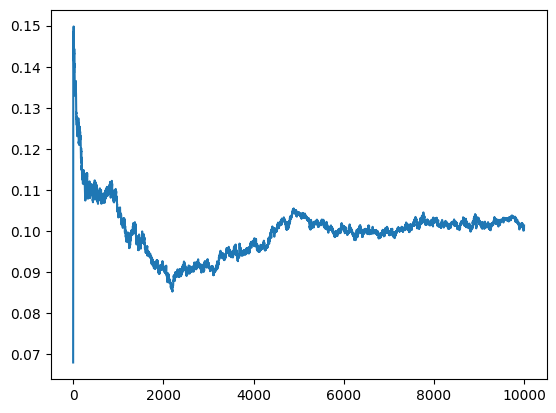

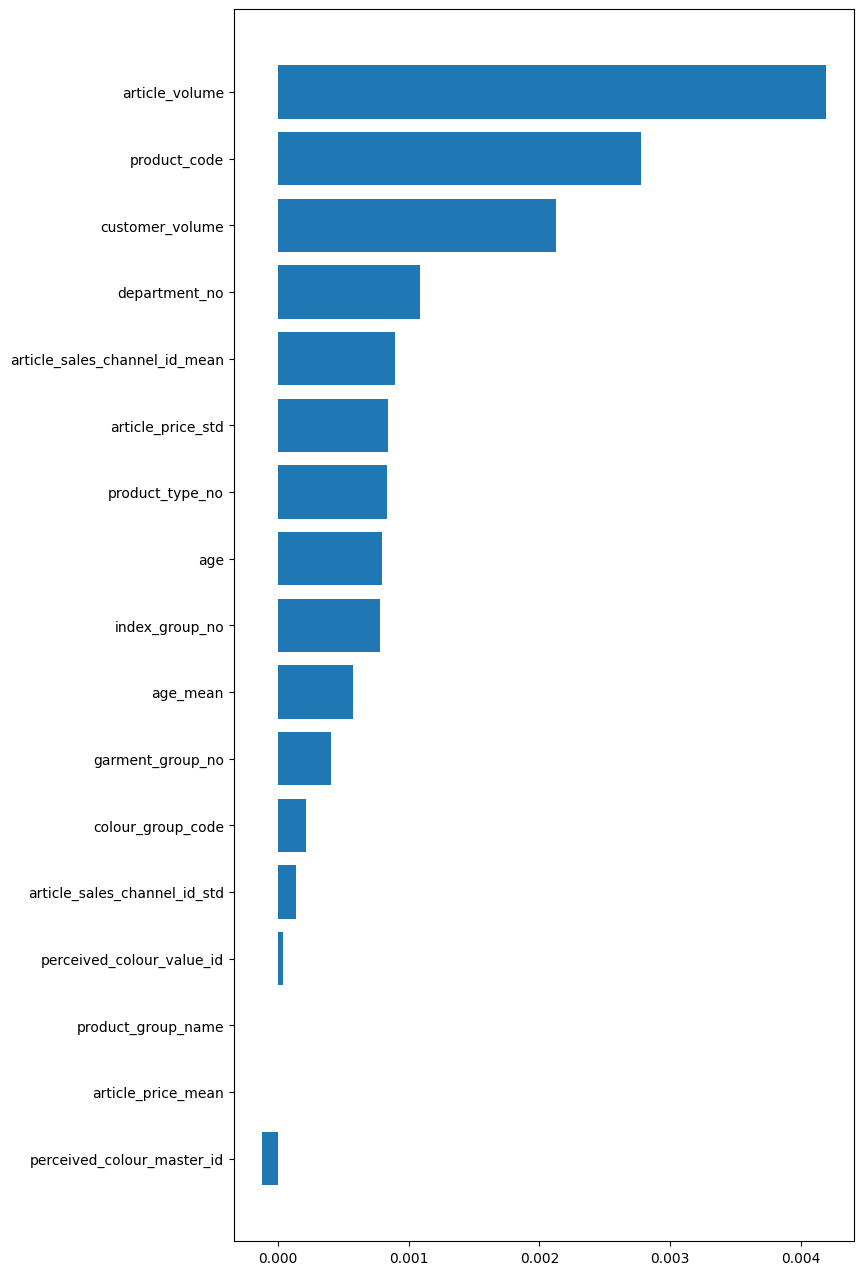

In [80]:
plt.plot(model.get_evals_result()['validation']['PFound']) # 打印验证结果

# 特征重要度
feature_importance = model.get_feature_importance(train_dataset)
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(8, 16))
plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

gc.collect()



# Validation


In [81]:
labelled_valid_df.sort_index(inplace=True)
pred = labelled_valid_df[['customer_id', 'article_id']].reset_index(drop=True) # 验证集的 user-item对
pred['pred'] = model.predict(labelled_valid_df[feature_columns]) # 验证集的 模型输出值


In [82]:
pred = pred.groupby(['customer_id', 'article_id'])['pred'].max().reset_index() # user-item对 的模型输出值 的最大值
pred = pred.sort_values(by=['customer_id', 'pred'], ascending=False).reset_index(drop=True).groupby('customer_id'
                                                                                                   )['article_id'].apply(lambda x: list(x)[:12]).reset_index() # 获取每个user 预测概率最大的前12个item

gt = transactions_df.query("t_dat>=@time_dicter[4][0]").groupby('customer_id')['article_id'].apply(list).reset_index().rename(columns={'article_id': 'gt'}) 
gt   

,customer_id,gt
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[0794321007]
1,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[0719530003, 0448509014]"
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,[0734592001]
3,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,[0624486001]
4,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,"[0889036004, 0827487003]"
...,...,...
82583,fffa7d7799eb390a76308454cbdd76e473d65b1497fbe4...,"[0861803014, 0849886010]"
82584,fffae8eb3a282d8c43c77dd2ca0621703b71e90904dfde...,"[0396135007, 0817472007, 0715624050, 081747200..."
82585,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,"[0509091057, 0859737002, 0573085028, 074568600..."
82586,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,"[0750423010, 0761269001]"


In [83]:
merged = pd.merge(pred, gt, on='customer_id', how='left') 
merged['article_id'] = merged['article_id'].fillna('').apply(list) # FN 填充为 ""
merged = merged.dropna()
merged

,customer_id,article_id,gt
0,00b32956428a096cde500df8a2c97b3efe6acf4d183977...,"[0918292001, 0751471001, 0924243001, 091852200...","[0915453001, 0903096002, 0889379008, 087481900..."
1,01179a3b2c4f0a9d447b44a6d0e3bd6ba79ac85f1f40de...,"[0918522001, 0924243001, 0915529003, 075147100...","[0886200001, 0809238001, 0903062001]"
2,02503777e62e3faaf38fb1297203abfdf749116ebbed5d...,"[0751471001, 0915526001, 0924243001, 089869400...","[0915611001, 0160442010, 0481781004, 0915611003]"
3,0325a4e1c47d5f107ddb720bba3a27cfa2af78b0c1acc5...,"[0918522001, 0924243001, 0915529003, 075147100...","[0929165002, 0925666003]"
4,039ce97fc66af4f7e7b1d48253e5ed8e7aabe8b6563c91...,"[0918522001, 0924243001, 0915526001, 086579900...","[0893141002, 0918525001, 0914118001, 0673677002]"
...,...,...,...
233,f8d5ddf12a0ac7e918fa7f7dd26d3d915dadeaa2c18c0e...,"[0918522001, 0924243001, 0915526001, 091552900...","[0889460001, 0673677002]"
234,fc453ef5d7f22f05ff890b39b018d353b3464c42fc8167...,"[0924243001, 0918522001, 0751471001, 091552600...","[0904416002, 0904416002, 0865929014, 086592901..."
235,fc8755b4eab7e8f83af747a6e19114716281d306ba798f...,"[0918522001, 0924243001, 0915529003, 075147100...",[0805000001]
236,fee8b241153e748c206d808f567d9fa9d31843f2d73db0...,"[0918522001, 0924243001, 0915529003, 075147100...","[0673677024, 0673677004, 0673677002, 090679400..."


In [84]:
def apk(actual, predicted, k=12):

    if len(predicted) > k:
        predicted = predicted[:k] # 截断12个预测值

    score = 0.0 
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]: # p not in predicted[:i] 意味着 pred不能重复出现
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0 # gt为空，返回0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=12):
   
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])


print('MAP@12:', mapk(merged['gt'], merged['article_id'])) # validation score calculation

MAP@12: 0.02561814552660891
